In [75]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from prophet import Prophet

# 设置中文字体（macOS）
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'STHeiti', 'PingFang SC']
plt.rcParams['axes.unicode_minus'] = False  


In [2]:
df = pd.read_csv('Exploratory Data Analysis(eda)/data.csv',encoding='latin1')

In [40]:

# 转换日期格式
df['tdate'] = pd.to_datetime(df['tdate'], errors='coerce')

# 删除日期为空的行
df = df[df['tdate'].notna()]
df = df[df['tdate'] >= '2013-01-01']

# 按月度聚合 - 计算每月的任务数量
monthly_data = df.groupby(df['tdate'].dt.to_period('M')).size().reset_index(name='count')
monthly_data['date'] = monthly_data['tdate'].astype(str) + '-01'
monthly_data['date'] = pd.to_datetime(monthly_data['date'])
monthly_data = monthly_data[['date', 'count']].sort_values('date').reset_index(drop=True)

print(f"月度数据统计:")
print(f"总月份数: {len(monthly_data)}")
print(f"时间范围: {monthly_data['date'].min()} 到 {monthly_data['date'].max()}")
print(f"平均每月任务数: {monthly_data['count'].mean():.2f}")
print(f"每月任务数范围: {monthly_data['count'].min()} - {monthly_data['count'].max()}")
print("\n前5个月数据:")
print(monthly_data.head())
print("\n后5个月数据:")
print(monthly_data.tail())

月度数据统计:
总月份数: 132
时间范围: 2013-01-01 00:00:00 到 2023-12-01 00:00:00
平均每月任务数: 134.56
每月任务数范围: 62 - 233

前5个月数据:
        date  count
0 2013-01-01     91
1 2013-02-01     72
2 2013-03-01    103
3 2013-04-01     72
4 2013-05-01     62

后5个月数据:
          date  count
127 2023-08-01    183
128 2023-09-01    186
129 2023-10-01    166
130 2023-11-01    203
131 2023-12-01    171


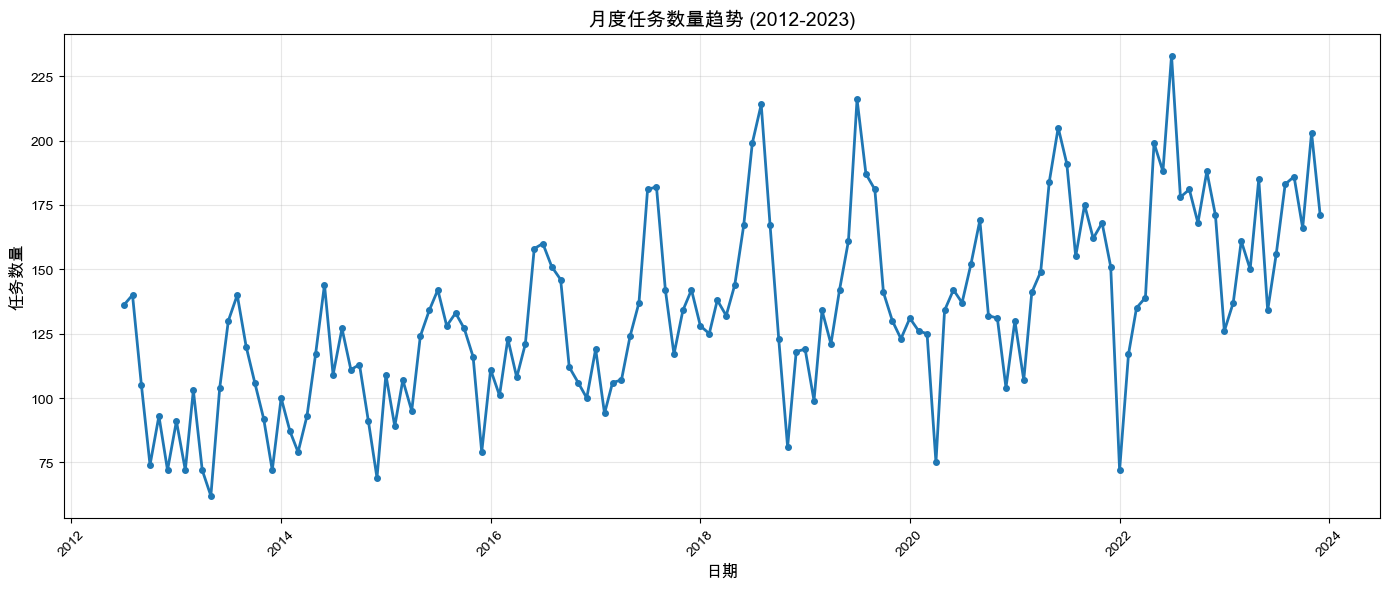


年度统计:
       sum        mean        std
date                             
2012   620  103.333333  29.540932
2013  1164   97.000000  24.852291
2014  1240  103.333333  21.089995
2015  1383  115.250000  19.725964
2016  1497  124.750000  22.696115
2017  1585  132.083333  27.523406
2018  1736  144.666667  36.755540
2019  1754  146.166667  33.795732
2020  1558  129.833333  23.280243
2021  1918  159.833333  27.222428
2022  1969  164.083333  42.455235
2023  1958  163.166667  23.728898


In [12]:

plt.figure(figsize=(14, 6))
plt.plot(monthly_data['date'], monthly_data['count'], marker='o', linewidth=2, markersize=4)
plt.title('月度任务数量趋势 (2012-2023)', fontsize=14, fontweight='bold')
plt.xlabel('日期', fontsize=12)
plt.ylabel('任务数量', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 年度统计
yearly_stats = monthly_data.groupby(monthly_data['date'].dt.year)['count'].agg(['sum', 'mean', 'std'])
print("\n年度统计:")
print(yearly_stats)

In [41]:
monthly_data

,date,count
0,2013-01-01,91
1,2013-02-01,72
2,2013-03-01,103
3,2013-04-01,72
4,2013-05-01,62
...,...,...
127,2023-08-01,183
128,2023-09-01,186
129,2023-10-01,166
130,2023-11-01,203


In [23]:
yearly_data = df.groupby(df['tdate'].dt.to_period('Y')).size().reset_index(name='count')
yearly_data['date'] = yearly_data['tdate'].astype(str) + '-01'
yearly_data['date'] = pd.to_datetime(yearly_data['date'])
yearly_data = yearly_data[['date', 'count']].sort_values('date').reset_index(drop=True)


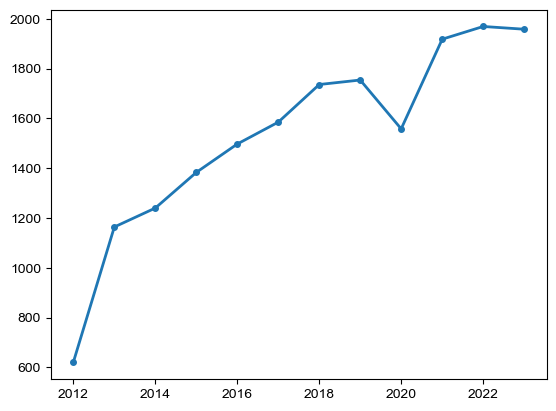

In [25]:
plt.plot(yearly_data['date'], yearly_data['count'], marker='o', linewidth=2, markersize=4)
plt.show()

# Prophet

In [ ]:
from prophet import Prophet

# 使用prophet模型来预测
def prophet_predict(data: pd.DataFrame, freq: str = 'M',
                    extra_vars: list[str] = [],
                    periods: int = 12, # 预测多少个月
                    growth: str = 'linear',
                    yearly_seasonality: bool = True,
                    weekly_seasonality: bool = False,
                    daily_seasonality: bool = False,
                    seasonality_mode: str = 'additive', # 季节性模式（加法或乘法）
                    changepoint_prior_scale: float = 0.05, # 趋势变化敏感度（越大越敏感，可能过拟合）
                    seasonality_prior_scale: float = 10.0, # 季节性敏感度（越大越敏感，可能过拟合）
                    interval_width: float = 0.95, # 置信区间宽度（越大越宽）
                    regressor_prior_scale: float = 0.05, # 回归变量敏感度（越大越敏感，可能过拟合）
                    regressor_mode: str = 'additive', # 回归变量模式（加法或乘法）
                    ):
    # 分离训练数据和未来数据（有count的用于训练，没有count的用于future）
    train_data = data[data['count'].notna()].copy()  # 只使用有count的数据进行训练
    future_data = data[data['count'].isna()].copy()  # 2024年的数据（没有count）
    prophet_data = train_data[['date', 'count']].copy()
    prophet_data.columns = ['ds', 'y']
    # 额外变量
    if extra_vars:
        for var in extra_vars:
            if var in train_data.columns:
                prophet_data[var] = pd.to_numeric(train_data[var], errors='coerce')
            else:
                print(f"警告: 变量 '{var}' 不在数据中，已跳过")
    model = Prophet(
        growth=growth,
        yearly_seasonality=yearly_seasonality,
        weekly_seasonality=weekly_seasonality,
        daily_seasonality=daily_seasonality,
        seasonality_mode=seasonality_mode,
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        interval_width=interval_width,
    )
    # 添加回归变量
    if extra_vars:
        for var in extra_vars:
            if var in prophet_data.columns:
                model.add_regressor(
                    var,
                    prior_scale=regressor_prior_scale,
                    mode=regressor_mode
                )
    model.fit(prophet_data)

    # 创建未来数据框 - 关键：使用 make_future_dataframe 确保包含历史数据
    # 计算需要预测的总月数
    if len(future_data) > 0:
        # 计算从训练数据最后日期到未来数据最后日期需要多少个月
        last_train_date = prophet_data['ds'].max()
        last_future_date = future_data['date'].max()
        months_needed = (last_future_date.year - last_train_date.year) * 12 + \
                       (last_future_date.month - last_train_date.month)
        periods = max(periods, months_needed)
    
    # 使用 make_future_dataframe 创建包含历史数据的 future
    future = model.make_future_dataframe(periods=periods, freq=freq)
    
    # 为 future 添加回归变量
    if extra_vars:
        for var in extra_vars:
            if var in prophet_data.columns:
                # 创建映射：历史数据使用训练数据，未来数据使用 future_data 或最后值
                var_values = {}
                
                # 历史数据部分：使用训练数据中的值
                for _, row in prophet_data.iterrows():
                    var_values[row['ds']] = row[var]
                
                # 未来数据部分（如果有）
                if len(future_data) > 0:
                    for _, row in future_data.iterrows():
                        var_values[pd.Timestamp(row['date'])] = pd.to_numeric(row[var], errors='coerce')
                
                # 填充 future：历史部分用训练数据，未来部分用 future_data 或最后值
                last_val = prophet_data[var].iloc[-1]
                future[var] = future['ds'].apply(
                    lambda x: var_values.get(x, last_val) if x in var_values else last_val
                )

    forecast = model.predict(future)
    return forecast,model


In [206]:
# prophet 验证：
from prophet.diagnostics import cross_validation, performance_metrics
# initial: 用于训练的初始数据量
# period: 每次预测之间的间隔
# horizon: 每次预测的长度
df_cv = cross_validation(
    model1,
    initial='730 days',  # 或 '2 years'
    period='365 days',    
    horizon='365 days'   # 或 '1 year'
)

# 计算性能指标
df_p = performance_metrics(df_cv)



  0%|          | 0/8 [00:00<?, ?it/s]

01:20:37 - cmdstanpy - INFO - Chain [1] start processing
01:20:37 - cmdstanpy - INFO - Chain [1] done processing
01:20:37 - cmdstanpy - INFO - Chain [1] start processing
01:20:37 - cmdstanpy - INFO - Chain [1] done processing
01:20:37 - cmdstanpy - INFO - Chain [1] start processing
01:20:37 - cmdstanpy - INFO - Chain [1] done processing
01:20:37 - cmdstanpy - INFO - Chain [1] start processing
01:20:37 - cmdstanpy - INFO - Chain [1] done processing
01:20:37 - cmdstanpy - INFO - Chain [1] start processing
01:20:37 - cmdstanpy - INFO - Chain [1] done processing
01:20:37 - cmdstanpy - INFO - Chain [1] start processing
01:20:37 - cmdstanpy - INFO - Chain [1] done processing
01:20:37 - cmdstanpy - INFO - Chain [1] start processing
01:20:37 - cmdstanpy - INFO - Chain [1] done processing
01:20:37 - cmdstanpy - INFO - Chain [1] start processing
01:20:37 - cmdstanpy - INFO - Chain [1] done processing


In [205]:
df_p[['mse','rmse','mape']].mean()

mse     675.117674
rmse     24.931271
mape      0.146878
dtype: float64

In [209]:
df_p[['mse','rmse','mape']].mean()

mse     772.282683
rmse     26.598750
mape      0.150904
dtype: float64

/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:548: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


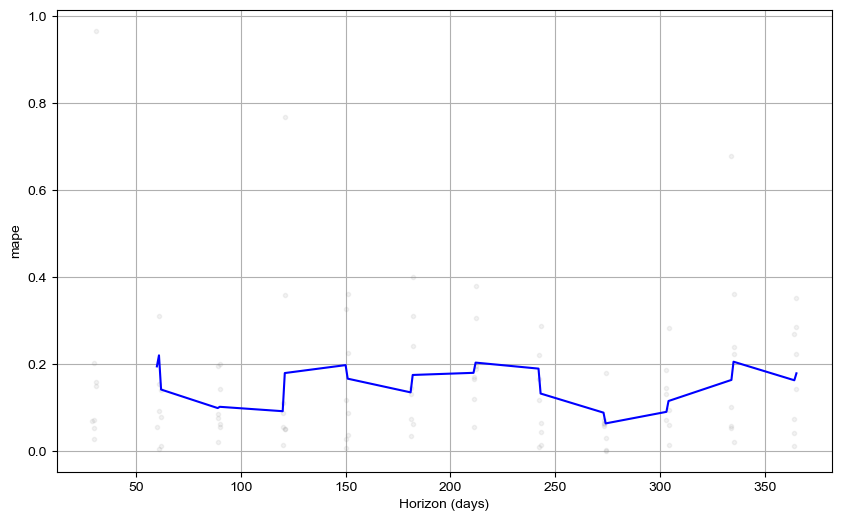

/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:548: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


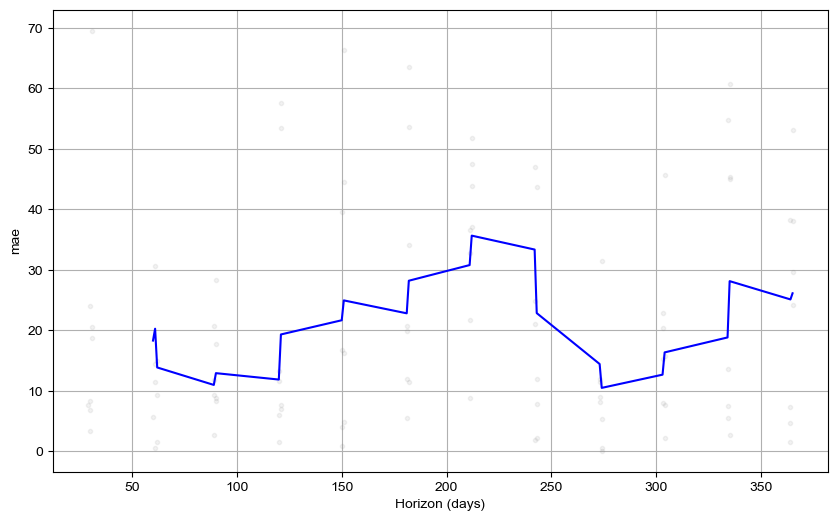

/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:548: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


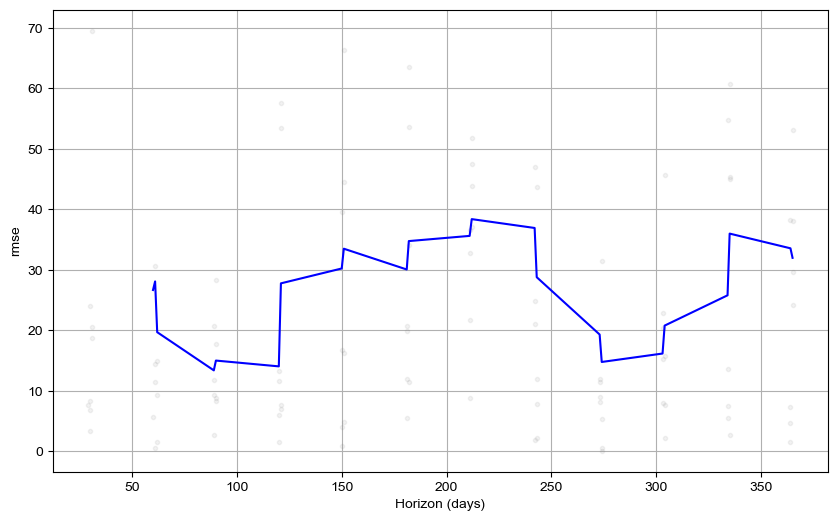

In [208]:
# 加入x
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.show()

# 或者看 MAE
fig = plot_cross_validation_metric(df_cv, metric='mae')
plt.show()

# 或者看 RMSE
fig = plot_cross_validation_metric(df_cv, metric='rmse')
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:548: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


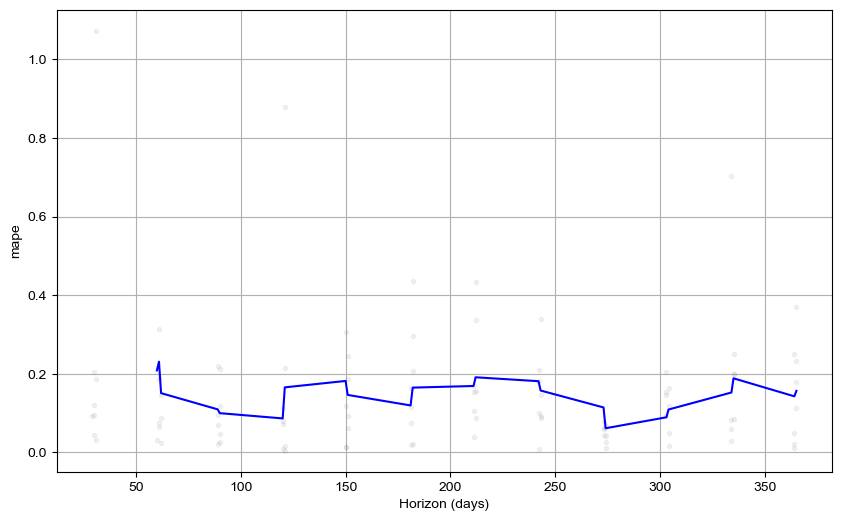

/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:548: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


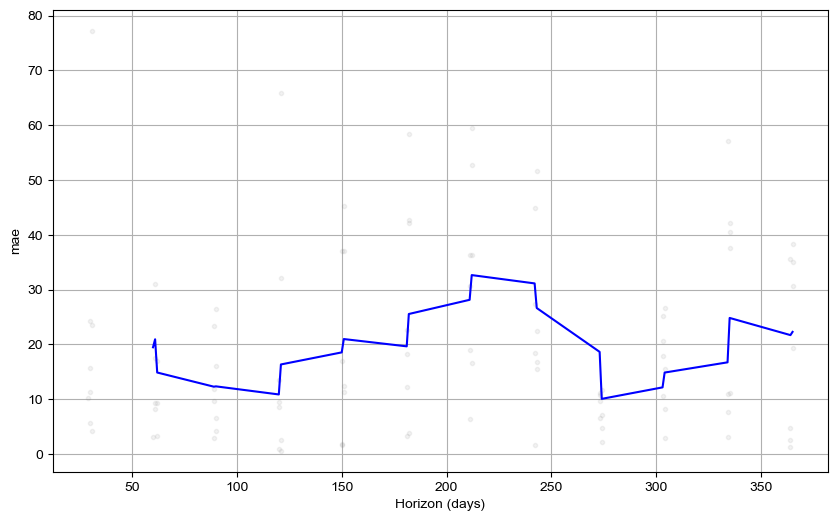

/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:548: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


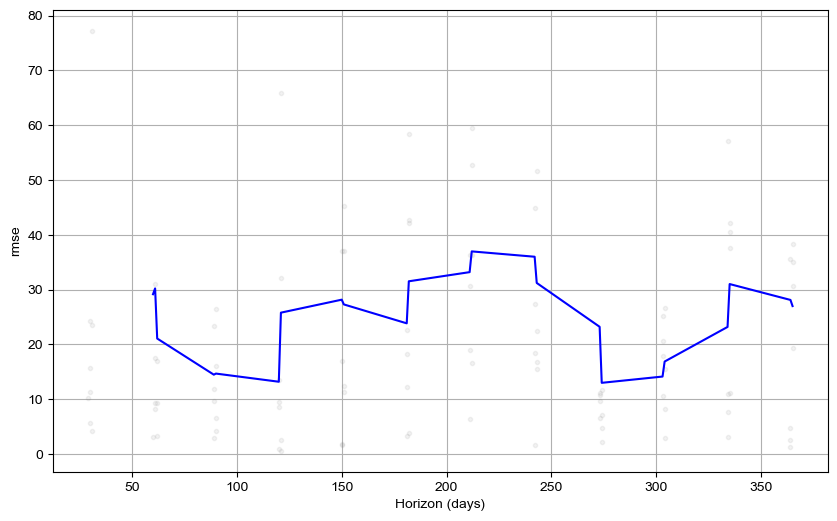

In [48]:
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.show()

# 或者看 MAE
fig = plot_cross_validation_metric(df_cv, metric='mae')
plt.show()

# 或者看 RMSE
fig = plot_cross_validation_metric(df_cv, metric='rmse')
plt.show()

## 不死心调整一下feature继续

In [210]:
df_monthly_merge

,date,count,year,month,NAME,state,age_under_5,age_5_9,age_10_19,age_20_29,...,age_10_19.1,age_20_29.1,age_30_39.1,age_40_49.1,age_50_59.1,age_60_69.1,age_70_79.1,age_80_84.1,age_85_plus.1,total_population
0,2013-01-01,91.0,2013,1,Maine,23.0,64177.0,70496.0,159483.0,157116.0,...,159483.0,157116.0,146376.0,180882.0,216316.0,174930.0,96160.0,33113.0,10262.0,1328302.0
1,2013-02-01,72.0,2013,2,Maine,23.0,64177.0,70496.0,159483.0,157116.0,...,159483.0,157116.0,146376.0,180882.0,216316.0,174930.0,96160.0,33113.0,10262.0,1328302.0
2,2013-03-01,103.0,2013,3,Maine,23.0,64177.0,70496.0,159483.0,157116.0,...,159483.0,157116.0,146376.0,180882.0,216316.0,174930.0,96160.0,33113.0,10262.0,1328302.0
3,2013-04-01,72.0,2013,4,Maine,23.0,64177.0,70496.0,159483.0,157116.0,...,159483.0,157116.0,146376.0,180882.0,216316.0,174930.0,96160.0,33113.0,10262.0,1328302.0
4,2013-05-01,62.0,2013,5,Maine,23.0,64177.0,70496.0,159483.0,157116.0,...,159483.0,157116.0,146376.0,180882.0,216316.0,174930.0,96160.0,33113.0,10262.0,1328302.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,2024-08-01,NaN,2024,8,Maine,23.0,58509.0,72063.0,148666.0,156709.0,...,148666.0,156709.0,179032.0,167105.0,180591.0,213995.0,157351.0,39071.0,12827.0,1405012.0
140,2024-09-01,NaN,2024,9,Maine,23.0,58509.0,72063.0,148666.0,156709.0,...,148666.0,156709.0,179032.0,167105.0,180591.0,213995.0,157351.0,39071.0,12827.0,1405012.0
141,2024-10-01,NaN,2024,10,Maine,23.0,58509.0,72063.0,148666.0,156709.0,...,148666.0,156709.0,179032.0,167105.0,180591.0,213995.0,157351.0,39071.0,12827.0,1405012.0
142,2024-11-01,NaN,2024,11,Maine,23.0,58509.0,72063.0,148666.0,156709.0,...,148666.0,156709.0,179032.0,167105.0,180591.0,213995.0,157351.0,39071.0,12827.0,1405012.0


In [212]:
df_monthly_merge['age_60_69_ratio'] = df_monthly_merge['age_60_69']/df_monthly_merge['total_population']

## 加入x预测

01:54:43 - cmdstanpy - INFO - Chain [1] start processing
01:54:43 - cmdstanpy - INFO - Chain [1] done processing
/opt/anaconda3/lib/python3.12/site-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


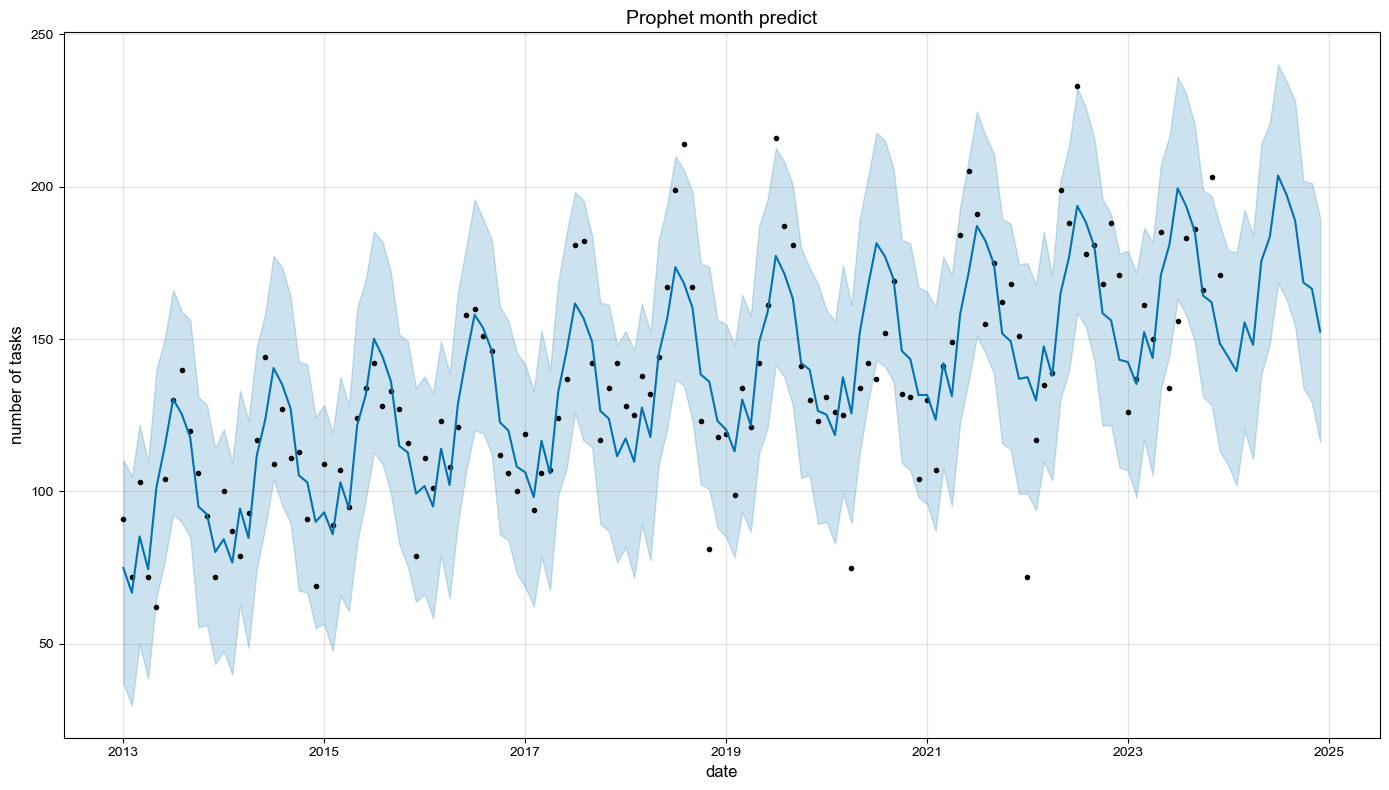

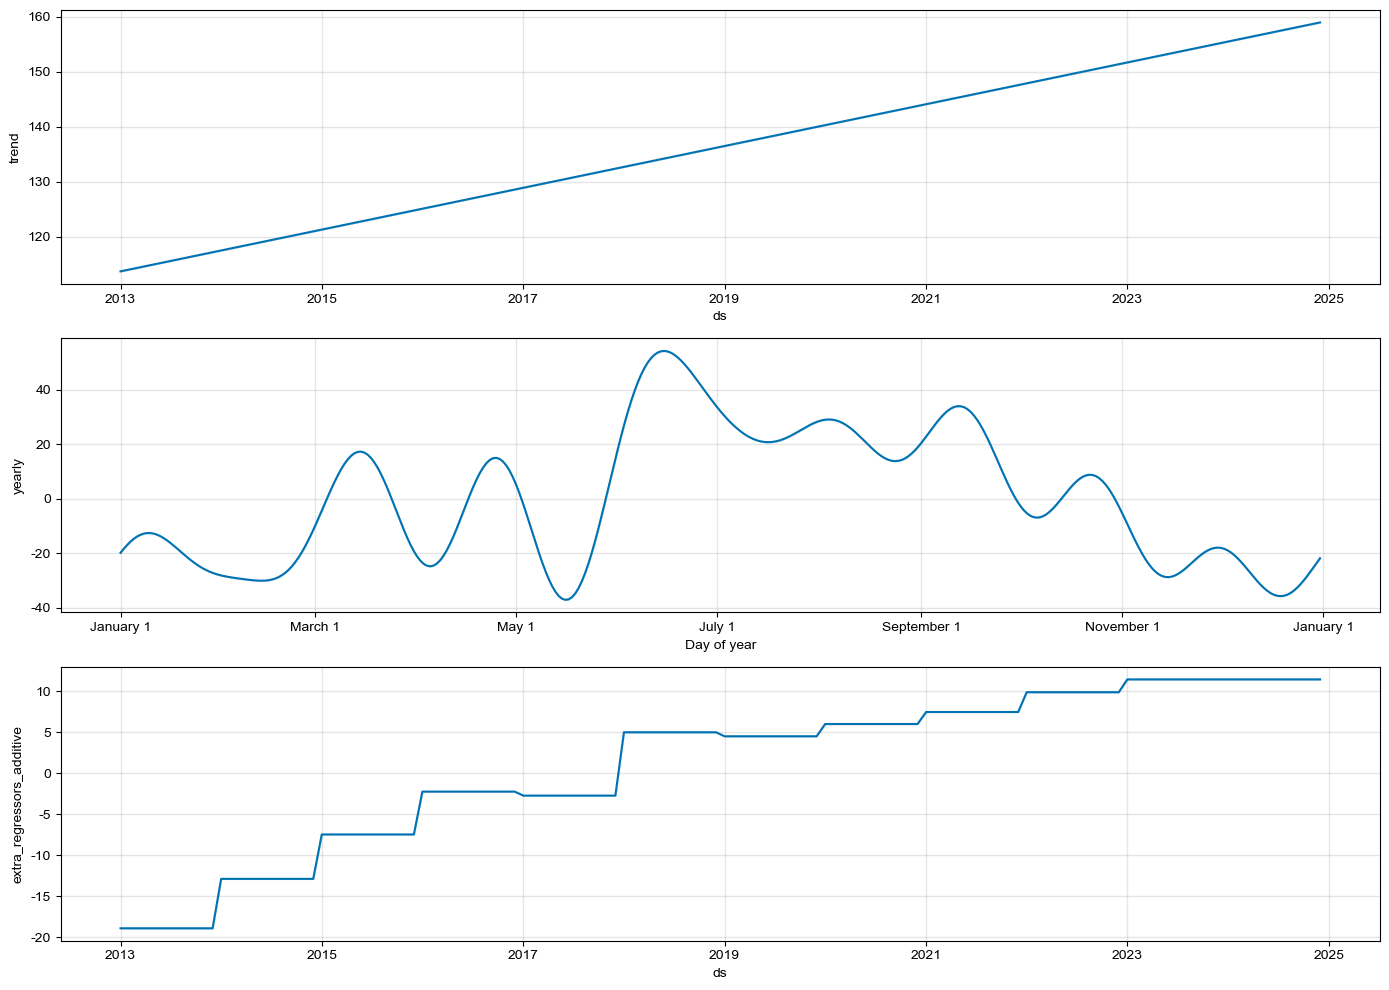

In [226]:
# 用extra_vars来预测
extra_vars = ['age_60_69_ratio']
res,model1 = prophet_predict(df_monthly_merge, extra_vars=extra_vars)

# 可视化结果
fig = model1.plot(res, figsize=(14, 8))
plt.title('Prophet month predict', fontsize=14, fontweight='bold')
plt.xlabel('date', fontsize=12)
plt.ylabel('number of tasks', fontsize=12)
plt.tight_layout()
plt.show()

# # # 显示预测结果
# print("\n未来12个月预测:")
# future_forecast = res[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(24)
# future_forecast.columns = ['日期', '预测值', '下限', '上限']
# print(future_forecast.to_string(index=False))

# # 显示组件（趋势和季节性）
fig2 = model1.plot_components(res, figsize=(14, 10))
plt.tight_layout()
plt.show()

In [231]:
res

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,age_60_69_ratio,...,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01,113.697548,37.027029,110.333964,113.697548,113.697548,-38.791430,-38.791430,-38.791430,-18.907389,...,-18.907389,-18.907389,-18.907389,-19.884041,-19.884041,-19.884041,0.0,0.0,0.0,74.906118
1,2013-02-01,114.020141,29.759245,104.971138,114.020141,114.020141,-47.232987,-47.232987,-47.232987,-18.907389,...,-18.907389,-18.907389,-18.907389,-28.325598,-28.325598,-28.325598,0.0,0.0,0.0,66.787154
2,2013-03-01,114.311515,49.873428,121.915514,114.311515,114.311515,-29.038983,-29.038983,-29.038983,-18.907389,...,-18.907389,-18.907389,-18.907389,-10.131594,-10.131594,-10.131594,0.0,0.0,0.0,85.272532
3,2013-04-01,114.634108,38.623078,109.710260,114.634108,114.634108,-40.140678,-40.140678,-40.140678,-18.907389,...,-18.907389,-18.907389,-18.907389,-21.233289,-21.233289,-21.233289,0.0,0.0,0.0,74.493429
4,2013-05-01,114.946294,65.282369,139.914948,114.946294,114.946294,-13.682958,-13.682958,-13.682958,-18.907389,...,-18.907389,-18.907389,-18.907389,5.224431,5.224431,5.224431,0.0,0.0,0.0,101.263336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,2024-07-31,157.705469,162.863954,234.378430,157.705468,157.705469,39.560394,39.560394,39.560394,11.432581,...,11.432581,11.432581,11.432581,28.127813,28.127813,28.127813,0.0,0.0,0.0,197.265863
140,2024-08-31,158.028062,154.274453,228.131338,158.028061,158.028063,30.760756,30.760756,30.760756,11.432581,...,11.432581,11.432581,11.432581,19.328175,19.328175,19.328175,0.0,0.0,0.0,188.788818
141,2024-09-30,158.340249,134.017778,201.883451,158.340248,158.340250,10.179563,10.179563,10.179563,11.432581,...,11.432581,11.432581,11.432581,-1.253018,-1.253018,-1.253018,0.0,0.0,0.0,168.519813
142,2024-10-31,158.662842,129.305271,201.141965,158.662841,158.662844,7.830633,7.830633,7.830633,11.432581,...,11.432581,11.432581,11.432581,-3.601948,-3.601948,-3.601948,0.0,0.0,0.0,166.493476


01:57:29 - cmdstanpy - INFO - Chain [1] start processing
01:57:29 - cmdstanpy - INFO - Chain [1] done processing
/opt/anaconda3/lib/python3.12/site-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


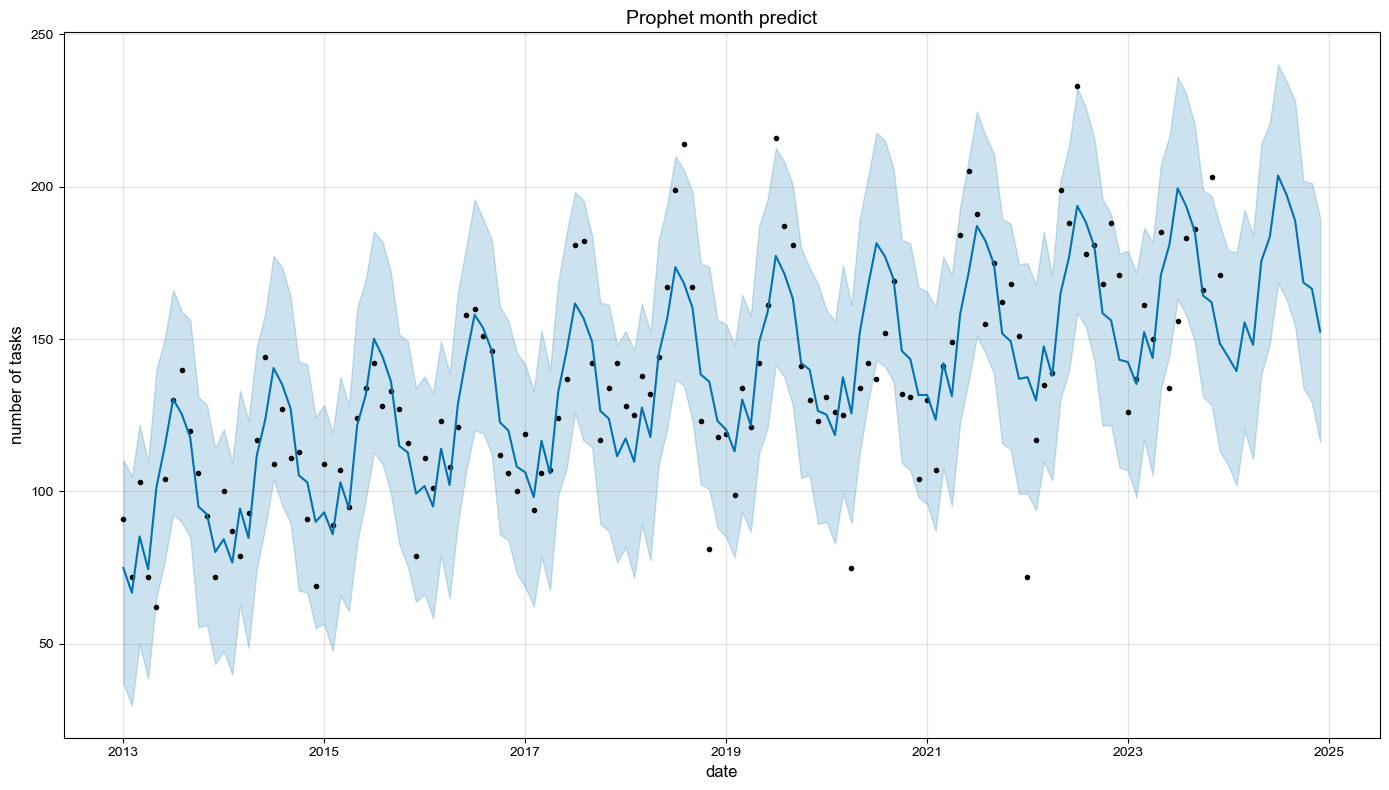

In [229]:
res2,model2 = prophet_predict(df_monthly_merge)

# 可视化结果
fig = model2.plot(res, figsize=(14, 8))
plt.title('Prophet month predict', fontsize=14, fontweight='bold')
plt.xlabel('date', fontsize=12)
plt.ylabel('number of tasks', fontsize=12)
plt.tight_layout()
plt.show()

In [230]:
res

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,age_60_69_ratio,...,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01,113.697548,37.027029,110.333964,113.697548,113.697548,-38.791430,-38.791430,-38.791430,-18.907389,...,-18.907389,-18.907389,-18.907389,-19.884041,-19.884041,-19.884041,0.0,0.0,0.0,74.906118
1,2013-02-01,114.020141,29.759245,104.971138,114.020141,114.020141,-47.232987,-47.232987,-47.232987,-18.907389,...,-18.907389,-18.907389,-18.907389,-28.325598,-28.325598,-28.325598,0.0,0.0,0.0,66.787154
2,2013-03-01,114.311515,49.873428,121.915514,114.311515,114.311515,-29.038983,-29.038983,-29.038983,-18.907389,...,-18.907389,-18.907389,-18.907389,-10.131594,-10.131594,-10.131594,0.0,0.0,0.0,85.272532
3,2013-04-01,114.634108,38.623078,109.710260,114.634108,114.634108,-40.140678,-40.140678,-40.140678,-18.907389,...,-18.907389,-18.907389,-18.907389,-21.233289,-21.233289,-21.233289,0.0,0.0,0.0,74.493429
4,2013-05-01,114.946294,65.282369,139.914948,114.946294,114.946294,-13.682958,-13.682958,-13.682958,-18.907389,...,-18.907389,-18.907389,-18.907389,5.224431,5.224431,5.224431,0.0,0.0,0.0,101.263336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,2024-07-31,157.705469,162.863954,234.378430,157.705468,157.705469,39.560394,39.560394,39.560394,11.432581,...,11.432581,11.432581,11.432581,28.127813,28.127813,28.127813,0.0,0.0,0.0,197.265863
140,2024-08-31,158.028062,154.274453,228.131338,158.028061,158.028063,30.760756,30.760756,30.760756,11.432581,...,11.432581,11.432581,11.432581,19.328175,19.328175,19.328175,0.0,0.0,0.0,188.788818
141,2024-09-30,158.340249,134.017778,201.883451,158.340248,158.340250,10.179563,10.179563,10.179563,11.432581,...,11.432581,11.432581,11.432581,-1.253018,-1.253018,-1.253018,0.0,0.0,0.0,168.519813
142,2024-10-31,158.662842,129.305271,201.141965,158.662841,158.662844,7.830633,7.830633,7.830633,11.432581,...,11.432581,11.432581,11.432581,-3.601948,-3.601948,-3.601948,0.0,0.0,0.0,166.493476


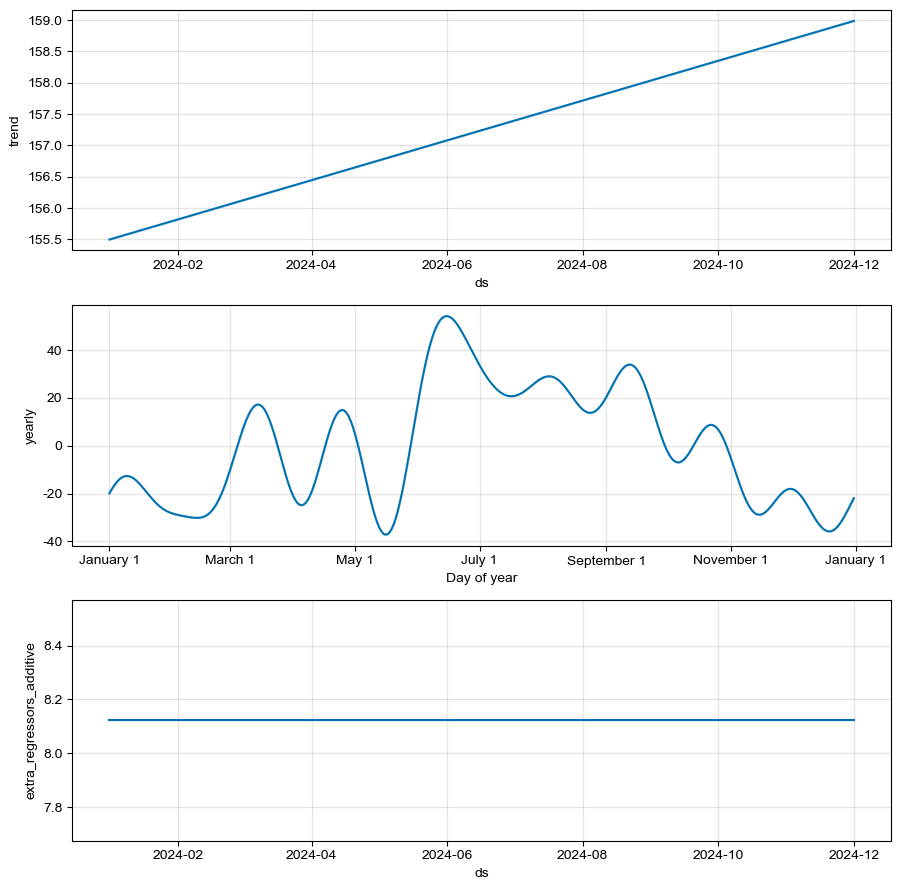

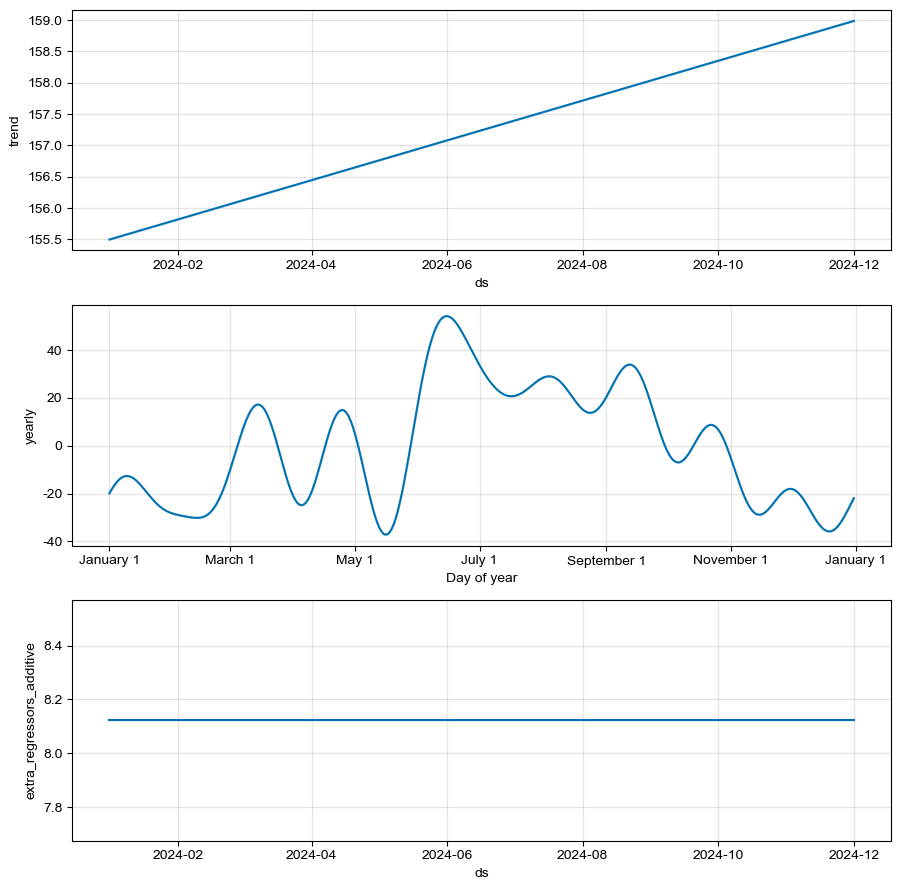

In [216]:
# prophet 验证：
from prophet.diagnostics import cross_validation, performance_metrics
# initial: 用于训练的初始数据量
# period: 每次预测之间的间隔
# horizon: 每次预测的长度
df_cv = cross_validation(
    model1,
    initial='730 days',  # 或 '2 years'
    period='365 days',    
    horizon='365 days'   # 或 '1 year'
)

# 计算性能指标
df_p = performance_metrics(df_cv)



  0%|          | 0/8 [00:00<?, ?it/s]

01:28:34 - cmdstanpy - INFO - Chain [1] start processing
01:28:34 - cmdstanpy - INFO - Chain [1] done processing
01:28:34 - cmdstanpy - INFO - Chain [1] start processing
01:28:34 - cmdstanpy - INFO - Chain [1] done processing
01:28:34 - cmdstanpy - INFO - Chain [1] start processing
01:28:34 - cmdstanpy - INFO - Chain [1] done processing
01:28:34 - cmdstanpy - INFO - Chain [1] start processing
01:28:34 - cmdstanpy - INFO - Chain [1] done processing
01:28:34 - cmdstanpy - INFO - Chain [1] start processing
01:28:34 - cmdstanpy - INFO - Chain [1] done processing
01:28:34 - cmdstanpy - INFO - Chain [1] start processing
01:28:35 - cmdstanpy - INFO - Chain [1] done processing
01:28:35 - cmdstanpy - INFO - Chain [1] start processing
01:28:35 - cmdstanpy - INFO - Chain [1] done processing
01:28:35 - cmdstanpy - INFO - Chain [1] start processing
01:28:35 - cmdstanpy - INFO - Chain [1] done processing


In [217]:
df_p[['mse','rmse','mape']].mean()

mse     641.034966
rmse     24.283590
mape      0.142832
dtype: float64

In [51]:
monthly_data.head(36)

,date,count
0,2013-01-01,91
1,2013-02-01,72
2,2013-03-01,103
3,2013-04-01,72
4,2013-05-01,62
5,2013-06-01,104
6,2013-07-01,130
7,2013-08-01,140
8,2013-09-01,120
9,2013-10-01,106


In [49]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2016-01-01,121.255887,105.379716,137.180856,111,2015-12-03
1,2016-02-01,97.852963,82.311521,113.222789,101,2015-12-03
2,2016-03-01,134.860484,118.808368,152.216046,123,2015-12-03
3,2016-04-01,108.887842,93.378648,125.709000,108,2015-12-03
4,2016-05-01,83.933097,67.096843,99.122116,121,2015-12-03
...,...,...,...,...,...,...
91,2023-08-01,199.809064,164.644768,234.040372,183,2022-12-01
92,2023-09-01,190.708977,158.640523,225.987839,186,2022-12-01
93,2023-10-01,168.863930,133.056665,205.291475,166,2022-12-01
94,2023-11-01,162.436490,126.097654,199.511050,203,2022-12-01


In [95]:
forecast_years = 5  # 修改这里：1, 2, 3, 5, 10等
forecast_months = forecast_years * 12

print(f"正在预测未来 {forecast_months} 个月（{forecast_months/12:.1f} 年）...")

# 预测未来N个月
future = model.make_future_dataframe(periods=forecast_months, freq='M')
forecast = model.predict(future)

正在预测未来 60 个月（5.0 年）...


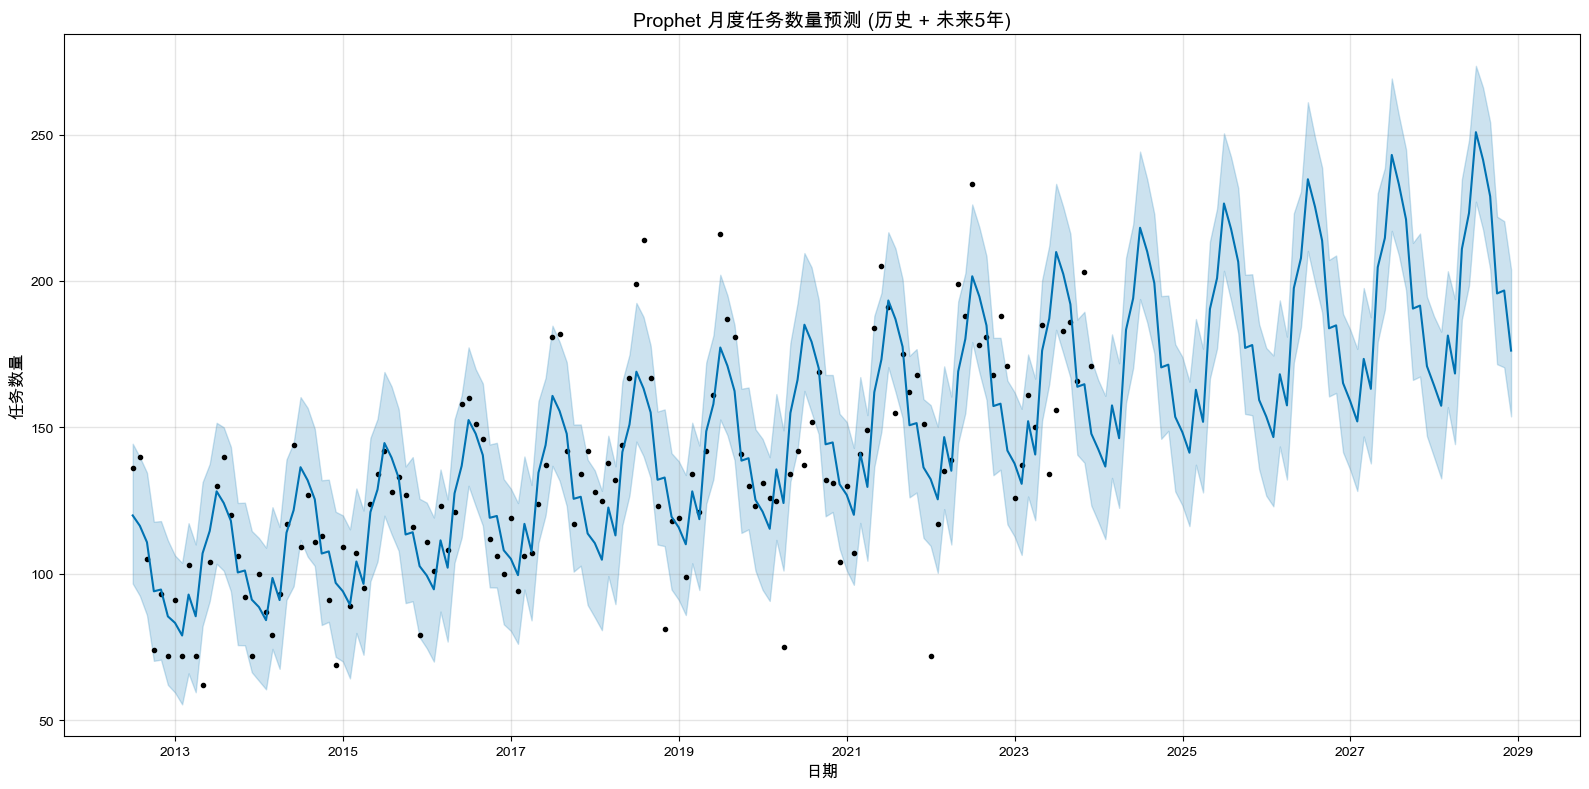

In [99]:
fig = model.plot(forecast, figsize=(16, 8))
plt.title(f'Prophet 月度任务数量预测 (历史 + 未来{forecast_years}年)', 
            fontsize=14, fontweight='bold')
plt.xlabel('日期', fontsize=12)
plt.ylabel('任务数量', fontsize=12)
plt.tight_layout()
plt.show()

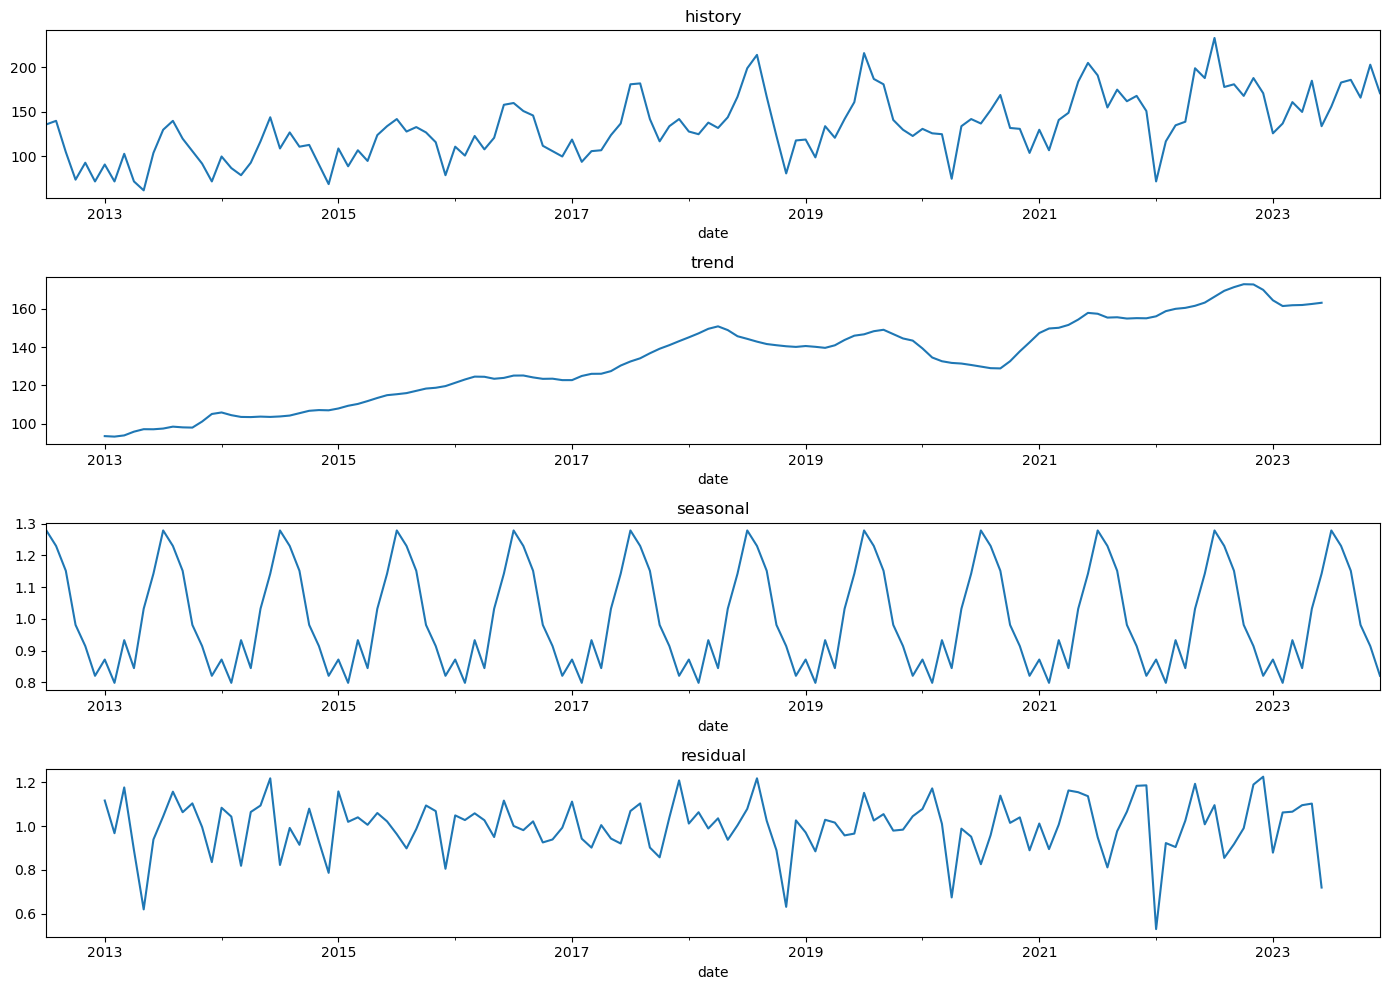

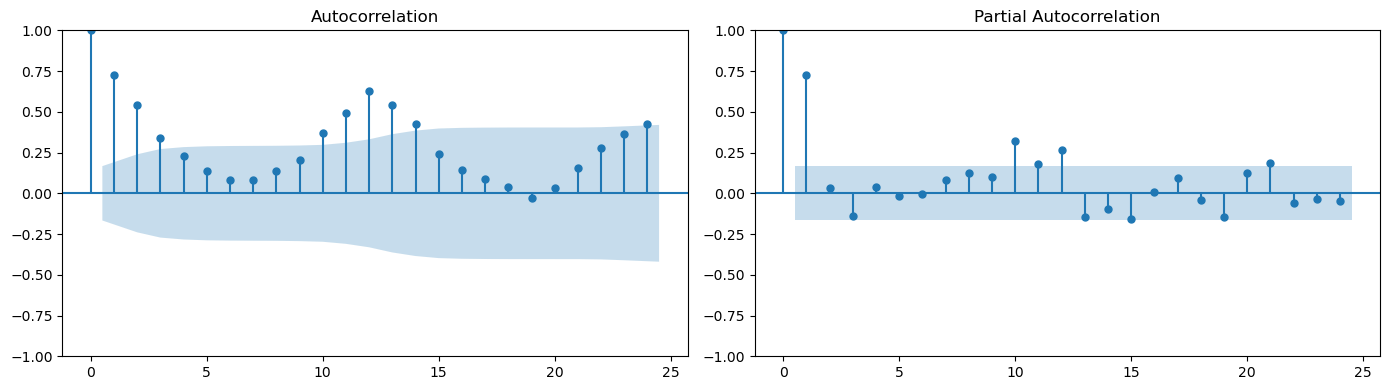

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



ARIMA 模型摘要:
                                    SARIMAX Results                                     
Dep. Variable:                            count   No. Observations:                  138
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -556.852
Date:                          Wed, 12 Nov 2025   AIC                           1123.703
Time:                                  15:02:39   BIC                           1137.845
Sample:                              07-01-2012   HQIC                          1129.448
                                   - 12-01-2023                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3969      0.088      4.527      0.000       0.225       0.569
ma.L1         -0.9998      4.176     -

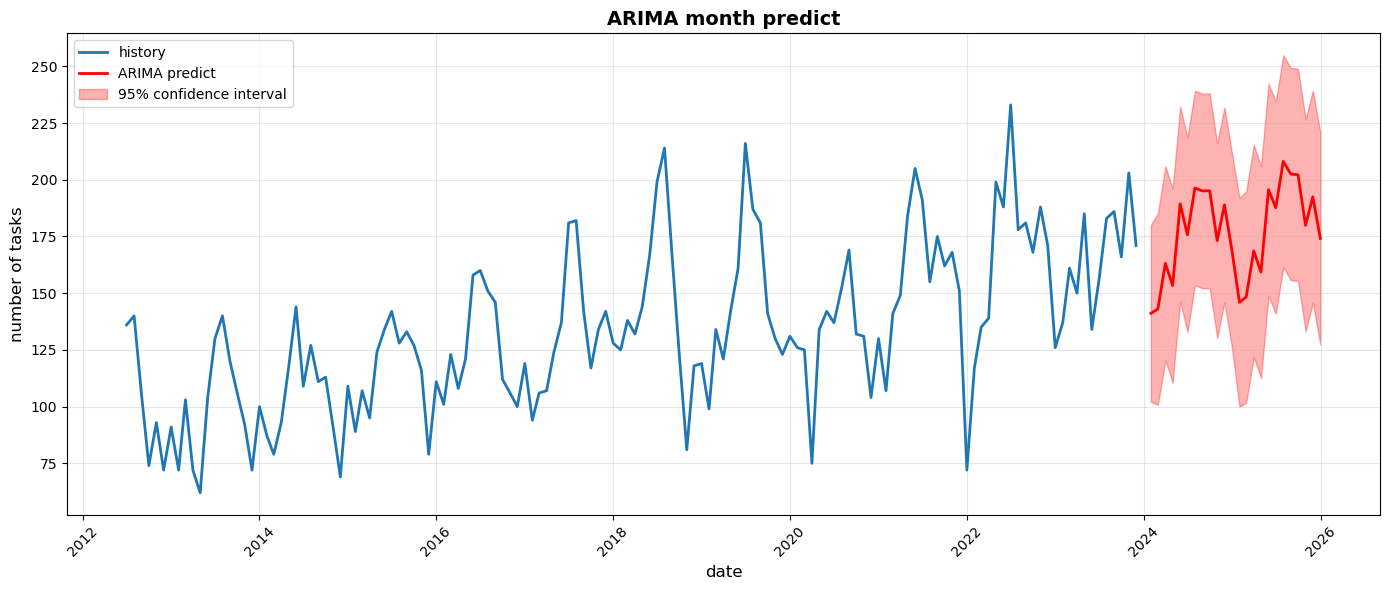


ARIMA 未来24个月预测:
        日期        预测值         下限         上限
2024-01-31 141.118586 102.104874 180.132297
2024-02-29 143.027985 100.862700 185.193270
2024-03-31 163.154734 120.439376 205.870092
2024-04-30 153.367787 110.536224 196.199350
2024-05-31 189.382045 146.518765 232.245325
2024-06-30 175.754762 132.877847 218.631678
2024-07-31 196.392915 153.504529 239.281300
2024-08-31 195.061704 152.172045 237.951364
2024-09-30 195.150058 152.259900 238.040217
2024-10-31 173.168167 130.277809 216.058526
2024-11-30 188.928525 146.038081 231.818969
2024-12-31 168.832536 125.942043 211.723028
2025-01-31 145.948281  99.954645 191.941917
2025-02-28 148.359167 101.796597 194.921736
2025-03-31 168.645045 121.953976 215.336115
2025-04-30 159.336069 112.608210 206.063929
2025-05-31 195.620398 148.877938 242.362858
2025-06-30 187.675774 140.922379 234.429169
2025-07-31 208.126999 161.358474 254.895524
2025-08-31 202.530489 155.761307 249.299671
2025-09-30 202.182645 155.413200 248.952091
2025-10-31 179.

In [ ]:

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 设置时间序列索引
ts = monthly_data.set_index('date')['count']

# 时间序列分解
decomposition = seasonal_decompose(ts, model='multiplicative', period=12)
fig, axes = plt.subplots(4, 1, figsize=(14, 10))
decomposition.observed.plot(ax=axes[0], title='history')
decomposition.trend.plot(ax=axes[1], title='trend')
decomposition.seasonal.plot(ax=axes[2], title='seasonal')
decomposition.resid.plot(ax=axes[3], title='residual')
plt.tight_layout()
plt.show()

# ACF 和 PACF 图（用于确定 ARIMA 参数）
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(ts, lags=24, ax=axes[0])
plot_pacf(ts, lags=24, ax=axes[1])
plt.tight_layout()
plt.show()

# 拟合 ARIMA 模型 (p, d, q) x (P, D, Q, s)
# 这里使用自动选择参数，你也可以手动调整
try:
    # 尝试 SARIMA 模型（季节性 ARIMA）
    model_arima = ARIMA(ts, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    fitted_model = model_arima.fit()
    
    print("\nARIMA 模型摘要:")
    print(fitted_model.summary())
    
    # 预测未来24个月
    forecast_arima = fitted_model.forecast(steps=24)
    forecast_ci = fitted_model.get_forecast(steps=24).conf_int()
    
    # 可视化 ARIMA 预测
    plt.figure(figsize=(14, 6))
    plt.plot(ts.index, ts.values, label='history', linewidth=2)
    
    # 创建未来日期
    last_date = ts.index[-1]
    future_dates = pd.date_range(start=last_date, periods=25, freq='M')[1:]
    
    plt.plot(future_dates, forecast_arima, label='ARIMA predict', linewidth=2, color='red')
    plt.fill_between(future_dates, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], 
                     alpha=0.3, color='red', label='95% confidence interval')
    plt.title('ARIMA month predict', fontsize=14, fontweight='bold')
    plt.xlabel('date', fontsize=12)
    plt.ylabel('number of tasks', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 显示预测结果
    arima_forecast_df = pd.DataFrame({
        '日期': future_dates,
        '预测值': forecast_arima,
        '下限': forecast_ci.iloc[:, 0],
        '上限': forecast_ci.iloc[:, 1]
    })
    print("\nARIMA 未来24个月预测:")
    print(arima_forecast_df.to_string(index=False))
    
except Exception as e:
    print(f"ARIMA 模型拟合出错: {e}")
    print("尝试使用更简单的模型...")

# Prophet模型，尝试加入外部变量

## 1. 适用于长期预测的变量 
人口和年龄结构

In [55]:
# 分析外部变量的相关性
# 只分析maine州的数据

# 人口和结构数据：
df_population = pd.read_csv('backend/data/1_demand_forecasting/MaineStateCountyPopulationProjections2042.csv')



In [241]:
# 人口预测数据
df_pop_pred = pd.read_csv(
    'backend/data/1_demand_forecasting/Maine State and County Population Projections, 2042. April 2025 Release.csv',
    sep='\t',
    engine='python',  # 使用 Python 引擎，更灵活
    skiprows=1,  # 跳过第一行
    encoding='ISO-8859-1',
    on_bad_lines='skip'  # 跳过有问题的行
)
df_pop_pred

, R e g i o n , , A g e   C o h o r t , 2 0 1 7 , 2 0 2 2 , 2 0 2 7 , 2 0 3 2 , 2 0 3 7 , 2 0 4 2 
0, M a i n e , F e m a l e   P o p u l a t i o n , 0 - 4 ," 3 1 , 3 7 8 "," 3 0 , 1 7 9 "," 2 9 , 9 5 2 "," 2 9 , 3 3 6 "," 2 8 , 4 6 3 "," 2 7 , 3 8 2 "
1, M a i n e , F e m a l e   P o p u l a t i o n , 5 - 9 ," 3 3 , 5 7 0 "," 3 3 , 2 9 8 "," 3 0 , 6 9 1 "," 3 0 , 5 2 2 "," 2 9 , 9 7 7 "," 2 9 , 1 5 5 "
2, M a i n e , F e m a l e   P o p u l a t i o n , 1 0 - 1 4 ," 3 7 , 0 2 2 "," 3 5 , 4 8 4 "," 3 3 , 7 3 4 "," 3 1 , 3 3 4 "," 3 1 , 2 0 4 "," 3 0 , 7 0 7 "
3, M a i n e , F e m a l e   P o p u l a t i o n , 1 5 - 1 9 ," 3 8 , 9 1 2 "," 3 9 , 2 8 2 "," 3 6 , 3 8 0 "," 3 4 , 5 7 3 "," 3 1 , 6 7 7 "," 3 1 , 5 9 4 "
4, M a i n e , F e m a l e   P o p u l a t i o n , 2 0 - 2 4 ," 3 7 , 2 5 7 "," 3 7 , 5 4 1 "," 3 7 , 9 6 4 "," 3 5 , 6 7 9 "," 3 3 , 1 2 6 "," 3 0 , 9 9 2 "
5, M a i n e , F e m a l e   P o p u l a t i o n , 2 5 - 2 9 ," 3 9 , 3 3 5 "," 3 9 , 6 1 7 "," 3 7 , 6 0 3 "," 3 7 , 6 5 2 "," 3 5 , 8 6 7 "," 3 3 , 4 9 5 "
6, M a i n e , F e m a l e   P o p u l a t i o n , 3 0 - 3 4 ," 3 9 , 6 4 3 "," 4 4 , 0 2 3 "," 4 1 , 4 2 0 "," 3 9 , 6 6 1 "," 3 9 , 5 6 6 "," 3 7 , 9 9 1 "
7, M a i n e , F e m a l e   P o p u l a t i o n , 3 5 - 3 9 ," 3 9 , 4 7 7 "," 4 3 , 2 5 5 "," 4 5 , 1 1 5 "," 4 3 , 3 4 2 "," 4 1 , 7 1 9 "," 4 1 , 5 6 1 "
8, M a i n e , F e m a l e   P o p u l a t i o n , 4 0 - 4 4 ," 3 8 , 2 0 3 "," 4 1 , 6 1 8 "," 4 4 , 3 8 6 "," 4 5 , 9 2 3 "," 4 4 , 6 9 7 "," 4 3 , 1 6 9 "
9, M a i n e , F e m a l e   P o p u l a t i o n , 4 5 - 4 9 ," 4 5 , 0 6 9 "," 3 9 , 2 2 4 "," 4 2 , 4 6 9 "," 4 5 , 2 8 8 "," 4 6 , 5 5 4 "," 4 5 , 7 6 9 "


In [267]:
df_p = pd.read_excel('/Users/guoyantong/Documents/cs7250/maine pred data.xls')

ImportError: Missing optional dependency 'xlrd'. Install xlrd >= 2.0.1 for xls Excel support Use pip or conda to install xlrd.

In [265]:
df_filtered

,Region,Gender,Age Cohort,2017,2022,2027,2032,2037,2042
0, M a i n e , F e m a l e   P o p u l a t i o n , 0 - 4 ," 3 1 , 3 7 8 "," 3 0 , 1 7 9 "," 2 9 , 9 5 2 "," 2 9 , 3 3 6 "," 2 8 , 4 6 3 "," 2 7 , 3 8 2 "
1, M a i n e , F e m a l e   P o p u l a t i o n , 5 - 9 ," 3 3 , 5 7 0 "," 3 3 , 2 9 8 "," 3 0 , 6 9 1 "," 3 0 , 5 2 2 "," 2 9 , 9 7 7 "," 2 9 , 1 5 5 "
2, M a i n e , F e m a l e   P o p u l a t i o n , 1 0 - 1 4 ," 3 7 , 0 2 2 "," 3 5 , 4 8 4 "," 3 3 , 7 3 4 "," 3 1 , 3 3 4 "," 3 1 , 2 0 4 "," 3 0 , 7 0 7 "
3, M a i n e , F e m a l e   P o p u l a t i o n , 1 5 - 1 9 ," 3 8 , 9 1 2 "," 3 9 , 2 8 2 "," 3 6 , 3 8 0 "," 3 4 , 5 7 3 "," 3 1 , 6 7 7 "," 3 1 , 5 9 4 "
4, M a i n e , F e m a l e   P o p u l a t i o n , 2 0 - 2 4 ," 3 7 , 2 5 7 "," 3 7 , 5 4 1 "," 3 7 , 9 6 4 "," 3 5 , 6 7 9 "," 3 3 , 1 2 6 "," 3 0 , 9 9 2 "
5, M a i n e , F e m a l e   P o p u l a t i o n , 2 5 - 2 9 ," 3 9 , 3 3 5 "," 3 9 , 6 1 7 "," 3 7 , 6 0 3 "," 3 7 , 6 5 2 "," 3 5 , 8 6 7 "," 3 3 , 4 9 5 "
6, M a i n e , F e m a l e   P o p u l a t i o n , 3 0 - 3 4 ," 3 9 , 6 4 3 "," 4 4 , 0 2 3 "," 4 1 , 4 2 0 "," 3 9 , 6 6 1 "," 3 9 , 5 6 6 "," 3 7 , 9 9 1 "
7, M a i n e , F e m a l e   P o p u l a t i o n , 3 5 - 3 9 ," 3 9 , 4 7 7 "," 4 3 , 2 5 5 "," 4 5 , 1 1 5 "," 4 3 , 3 4 2 "," 4 1 , 7 1 9 "," 4 1 , 5 6 1 "
8, M a i n e , F e m a l e   P o p u l a t i o n , 4 0 - 4 4 ," 3 8 , 2 0 3 "," 4 1 , 6 1 8 "," 4 4 , 3 8 6 "," 4 5 , 9 2 3 "," 4 4 , 6 9 7 "," 4 3 , 1 6 9 "
9, M a i n e , F e m a l e   P o p u l a t i o n , 4 5 - 4 9 ," 4 5 , 0 6 9 "," 3 9 , 2 2 4 "," 4 2 , 4 6 9 "," 4 5 , 2 8 8 "," 4 6 , 5 5 4 "," 4 5 , 7 6 9 "


In [259]:
print(df_pop_pred.columns.tolist())
print(df_pop_pred.head())

['Region', 'Gender', 'Age Cohort', '2017', '2022', '2027', '2032', '2037', '2042']
        Region                               Gender   Age Cohort  \
0   M a i n e    F e m a l e   P o p u l a t i o n        0 - 4    
1   M a i n e    F e m a l e   P o p u l a t i o n        5 - 9    
2   M a i n e    F e m a l e   P o p u l a t i o n    1 0 - 1 4    
3   M a i n e    F e m a l e   P o p u l a t i o n    1 5 - 1 9    
4   M a i n e    F e m a l e   P o p u l a t i o n    2 0 - 2 4    

            2017           2022           2027           2032           2037  \
0   3 1 , 3 7 8    3 0 , 1 7 9    2 9 , 9 5 2    2 9 , 3 3 6    2 8 , 4 6 3    
1   3 3 , 5 7 0    3 3 , 2 9 8    3 0 , 6 9 1    3 0 , 5 2 2    2 9 , 9 7 7    
2   3 7 , 0 2 2    3 5 , 4 8 4    3 3 , 7 3 4    3 1 , 3 3 4    3 1 , 2 0 4    
3   3 8 , 9 1 2    3 9 , 2 8 2    3 6 , 3 8 0    3 4 , 5 7 3    3 1 , 6 7 7    
4   3 7 , 2 5 7    3 7 , 5 4 1    3 7 , 9 6 4    3 5 , 6 7 9    3 3 , 1 2 6    

            2042  
0   2 7 

In [261]:
# 用于计算2025-2035 的预测人口
df_filtered = df_pop_pred[df_pop_pred['Age Cohort'] != 'Total'].copy()

In [146]:
import pandas as pd
import requests
import time
from typing import Dict

# 人口历史数据
columns = [f'B01001_0{i:02d}E' for i in range(1, 49)]
columns = ['NAME', *columns]
columns_str = ','.join(columns)

# 年份范围
years = range(2013, 2025)
# 去掉2020年
years = [year for year in years if year != 2020]
# 存储所有年份的数据
all_data = {}

def fetch_census_data(year: int, max_retries: int = 3) -> pd.DataFrame:
    """获取指定年份的 Census 数据"""
    url = f'https://api.census.gov/data/{year}/acs/acs1?get={columns_str}&for=state:23'
    
    for attempt in range(max_retries):
        try:
            response = requests.get(url, timeout=30)
            response.raise_for_status()
            data = response.json()
            
            if len(data) > 1:
                df = pd.DataFrame(data[1:], columns=data[0])
                df['year'] = year
                return df
            else:
                print(f"⚠ {year} 年数据为空")
                return None
                
        except requests.exceptions.RequestException as e:
            if attempt < max_retries - 1:
                print(f"⚠ {year} 年请求失败，重试中... ({attempt + 1}/{max_retries})")
                time.sleep(1)
            else:
                print(f"✗ {year} 年数据获取失败: {e}")
                return None
        except Exception as e:
            print(f"✗ {year} 年数据处理失败: {e}")
            return None
    
    return None

# 获取所有年份的数据
print("开始获取 Census API 数据...\n")

for year in years:
    print(f"正在获取 {year} 年数据...", end=' ')
    df = fetch_census_data(year)
    if df is not None:
        all_data[year] = df
        print(f"✓ 成功 ({len(df)} 行)")
    else:
        print(f"✗ 失败")
    time.sleep(0.5)  # 避免请求过快

# 合并数据
if all_data:
    df_all = pd.concat(all_data.values(), ignore_index=True)
    
    print(f"\n合并完成！")
    print(f"总行数: {len(df_all)}")
    print(f"年份: {sorted(df_all['year'].unique())}")
    print(f"\n前5行:")
    print(df_all.head())
    
    # 保存
    # output_file = 'backend/data/1_demand_forecasting/census_population_2013_2022.csv'
    # df_all.to_csv(output_file, index=False)
    # print(f"\n数据已保存到: {output_file}")
else:
    print("\n没有获取到任何数据！")

开始获取 Census API 数据...

正在获取 2013 年数据... ✓ 成功 (1 行)
正在获取 2014 年数据... ✓ 成功 (1 行)
正在获取 2015 年数据... ✓ 成功 (1 行)
正在获取 2016 年数据... ✓ 成功 (1 行)
正在获取 2017 年数据... ✓ 成功 (1 行)
正在获取 2018 年数据... ✓ 成功 (1 行)
正在获取 2019 年数据... ✓ 成功 (1 行)
正在获取 2021 年数据... ✓ 成功 (1 行)
正在获取 2022 年数据... ✓ 成功 (1 行)
正在获取 2023 年数据... ✓ 成功 (1 行)
正在获取 2024 年数据... ✓ 成功 (1 行)

合并完成！
总行数: 11
年份: [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2021, 2022, 2023, 2024]

前5行:
    NAME B01001_001E B01001_002E B01001_003E B01001_004E B01001_005E  \
0  Maine     1328302      649994       32373       36705       39051   
1  Maine     1330089      647622       31581       36972       37266   
2  Maine     1329328      651030       32056       35922       39426   
3  Maine     1331479      650702       32762       38158       35053   
4  Maine     1335907      654763       32516       36059       37760   

  B01001_006E B01001_007E B01001_008E B01001_009E  ... B01001_041E  \
0       25301       17520        9626        9051  ...       54352   
1   

In [147]:
# 保存数据
output_file = 'backend/data/1_demand_forecasting/acs1_population_2013_2024.csv'
df_all.to_csv(output_file, index=False)
print(f"\n数据已保存到: {output_file}")


数据已保存到: backend/data/1_demand_forecasting/acs1_population_2013_2024.csv


In [148]:
df_his = df_all

In [149]:
numeric_cols = [col for col in df_his.columns if col.startswith('B01001_')]

In [81]:
yearly_data['year'] = yearly_data['date'].dt.year

In [83]:
df_pop_merge = pd.merge(yearly_data, df_his, on='year', how='inner')
df_pop_merge


,date,count,year,NAME,B01001_001E,B01001_002E,B01001_003E,B01001_004E,B01001_005E,B01001_006E,...,B01001_040E,B01001_041E,B01001_042E,B01001_043E,B01001_044E,B01001_045E,B01001_046E,B01001_047E,B01001_048E,state
0,2013-01-01,1164,2013,Maine,1328302,649994,32373,36705,39051,25301,...,55612,54352,22890,28846,19846,20853,28298,21860,19888,23
1,2014-01-01,1240,2014,Maine,1330089,647622,31581,36972,37266,24650,...,55621,56561,21664,29041,19013,22559,30532,21490,18837,23
2,2015-01-01,1383,2015,Maine,1329328,651030,32056,35922,39426,24727,...,53603,57663,20380,30299,19768,25124,31370,22761,16929,23
3,2016-01-01,1497,2016,Maine,1331479,650702,32762,38158,35053,24217,...,51368,54756,23968,29362,18628,27943,32053,23118,17400,23
4,2017-01-01,1585,2017,Maine,1335907,654763,32516,36059,37760,24118,...,49762,54337,24201,30566,21589,25928,34608,23364,16935,23
5,2018-01-01,1736,2018,Maine,1338404,655734,32681,35539,36361,23815,...,48766,56096,22043,32958,21098,25935,38787,25907,17270,23
6,2019-01-01,1754,2019,Maine,1344212,656330,32093,32704,37521,23240,...,47375,53387,21912,33817,20809,28642,39399,25090,18448,23
7,2021-01-01,1918,2021,Maine,1372247,673483,31287,32380,40033,23352,...,45119,51435,23622,35024,20295,29673,45783,28421,18108,23
8,2022-01-01,1969,2022,Maine,1385340,684557,32126,35275,35967,23084,...,45562,51729,23038,33206,22758,30253,43832,30579,20684,23
9,2023-01-01,1958,2023,Maine,1395722,685126,30229,33734,38332,23928,...,46052,49620,20840,36719,23641,30458,45124,32327,22725,23


In [157]:
# 处理一下历史人口数据

# 定义年龄组和对应的列索引
# 男性列索引：2-24 (B01001_003E 到 B01001_025E)
# 女性列索引：25-47 (B01001_027E 到 B01001_049E)

# 列名列表（假设 df_his 的列顺序是固定的）
male_cols = [f'B01001_{i:03d}E' for i in range(3, 26)]  # B01001_003E 到 B01001_025E
female_cols = [f'B01001_{i:03d}E' for i in range(27, 50)]  # B01001_027E 到 B01001_049E

# 定义年龄组映射（索引从0开始）
age_group_mapping = {
    'under_5': {
        'male_idx': [0],  # B01001_003E
        'female_idx': [0]  # B01001_027E
    },
    '5_9': {
        'male_idx': [1],  # B01001_004E
        'female_idx': [1]  # B01001_028E
    },
    '10_19': {
        'male_idx': [2, 3, 4],  # 10-14, 15-17, 18-19
        'female_idx': [2, 3, 4]
    },
    '20_29': {
        'male_idx': [5, 6, 7, 8],  # 20, 21, 22-24, 25-29
        'female_idx': [5, 6, 7, 8]
    },
    '30_39': {
        'male_idx': [9, 10],  # 30-34, 35-39
        'female_idx': [9, 10]
    },
    '40_49': {
        'male_idx': [11, 12],  # 40-44, 45-49
        'female_idx': [11, 12]
    },
    '50_59': {
        'male_idx': [13, 14],  # 50-54, 55-59
        'female_idx': [13, 14]
    },
    '60_69': {
        'male_idx': [15, 16, 17, 18],  # 60-61, 62-64, 65-66, 67-69
        'female_idx': [15, 16, 17, 18]
    },
    '70_79': {
        'male_idx': [19, 20],  # 70-74, 75-79
        'female_idx': [19, 20]
    },
    '80_84': {
        'male_idx': [21],  # 80-84
        'female_idx': [21]
    },
    '85_plus': {
        'male_idx': [22],  # 85+
        'female_idx': [22]
    }
}

# 创建新的 DataFrame
df_merged = df_his.copy()

# 检查哪些列实际存在
available_male_cols = [col for col in male_cols if col in df_merged.columns]
available_female_cols = [col for col in female_cols if col in df_merged.columns]

print(f"找到 {len(available_male_cols)} 个男性列")
print(f"找到 {len(available_female_cols)} 个女性列")

# 为每个年龄组计算合并值
for age_group, mapping in age_group_mapping.items():
    # 获取对应的列名
    male_cols_to_sum = [male_cols[i] for i in mapping['male_idx'] if i < len(available_male_cols)]
    female_cols_to_sum = [female_cols[i] for i in mapping['female_idx'] if i < len(available_female_cols)]
    
    # 计算总和
    male_sum = df_merged[male_cols_to_sum].apply(pd.to_numeric, errors='coerce').sum(axis=1)
    female_sum = df_merged[female_cols_to_sum].apply(pd.to_numeric, errors='coerce').sum(axis=1)
    
    # 合并
    df_merged[f'age_{age_group}'] = male_sum + female_sum

# 选择最终列（保留标识列和新的年龄组列）
identifier_cols = [col for col in df_merged.columns if not col.startswith('B01001_')]
age_group_cols = [f'age_{group}' for group in age_group_mapping.keys()]

df_final = df_merged[identifier_cols + age_group_cols].copy()

print("\n" + "="*60)
print("合并完成")
print("="*60)
print(f"\n数据形状: {df_final.shape}")
print(f"\n列名:")
print(df_final.columns.tolist())
print(f"\n前5行:")
print(df_final.head())

找到 23 个男性列
找到 22 个女性列

合并完成

数据形状: (11, 25)

列名:
['NAME', 'state', 'year', 'age_under_5', 'age_5_9', 'age_10_19', 'age_20_29', 'age_30_39', 'age_40_49', 'age_50_59', 'age_60_69', 'age_70_79', 'age_80_84', 'age_85_plus', 'age_under_5', 'age_5_9', 'age_10_19', 'age_20_29', 'age_30_39', 'age_40_49', 'age_50_59', 'age_60_69', 'age_70_79', 'age_80_84', 'age_85_plus']

前5行:
    NAME state  year  age_under_5  age_5_9  age_10_19  age_20_29  age_30_39  \
0  Maine    23  2013        64177    70496     159483     157116     146376   
1  Maine    23  2014        62917    71830     157385     155225     149807   
2  Maine    23  2015        63852    69349     155963     155116     146320   
3  Maine    23  2016        63941    74853     151051     154906     150954   
4  Maine    23  2017        64390    69707     155800     154002     155585   

   age_40_49  age_50_59  ...  age_5_9  age_10_19  age_20_29  age_30_39  \
0     180882     216316  ...    70496     159483     157116     146376   
1     

In [158]:
df_final

,NAME,state,year,age_under_5,age_5_9,age_10_19,age_20_29,age_30_39,age_40_49,age_50_59,...,age_5_9,age_10_19,age_20_29,age_30_39,age_40_49,age_50_59,age_60_69,age_70_79,age_80_84,age_85_plus
0,Maine,23,2013,64177,70496,159483,157116,146376,180882,216316,...,70496,159483,157116,146376,180882,216316,174930,96160,33113,10262.0
1,Maine,23,2014,62917,71830,157385,155225,149807,174208,217565,...,71830,157385,155225,149807,174208,217565,181275,96753,31764,11031.0
2,Maine,23,2015,63852,69349,155963,155116,146320,172948,215600,...,69349,155963,155116,146320,172948,215600,186662,102504,28990,10673.0
3,Maine,23,2016,63941,74853,151051,154906,150954,169302,209868,...,74853,151051,154906,150954,169302,209868,192267,99895,29246,14109.0
4,Maine,23,2017,64390,69707,155800,154002,155585,161790,206173,...,69707,155800,154002,155585,161790,206173,192410,111462,29842,12374.0
5,Maine,23,2018,63410,67860,149874,153580,160310,158300,200748,...,67860,149874,153580,160310,158300,200748,200651,117404,31418,12650.0
6,Maine,23,2019,62813,64874,151079,156462,159657,160070,194682,...,64874,151079,156462,159657,160070,194682,201020,127433,31469,11055.0
7,Maine,23,2021,61034,69073,149478,156639,174806,158475,194658,...,69073,149478,156639,174806,158475,194658,208309,139081,31632,11472.0
8,Maine,23,2022,61018,69458,144970,159207,175007,160086,192173,...,69458,144970,159207,175007,160086,192173,212846,141410,36126,12164.0
9,Maine,23,2023,59898,66379,152578,157211,173981,167172,186190,...,66379,152578,157211,173981,167172,186190,216104,146656,39057,12528.0


In [159]:
df_final['total_population'] = df_his['B01001_001E']

In [163]:
# 保存为csv
df_final.to_csv('backend/data/1_demand_forecasting/acs1_population_2013_2024_age_group.csv', index=False)
df_final

,NAME,state,year,age_under_5,age_5_9,age_10_19,age_20_29,age_30_39,age_40_49,age_50_59,...,age_10_19,age_20_29,age_30_39,age_40_49,age_50_59,age_60_69,age_70_79,age_80_84,age_85_plus,total_population
0,Maine,23,2013,64177,70496,159483,157116,146376,180882,216316,...,159483,157116,146376,180882,216316,174930,96160,33113,10262.0,1328302
1,Maine,23,2014,62917,71830,157385,155225,149807,174208,217565,...,157385,155225,149807,174208,217565,181275,96753,31764,11031.0,1330089
2,Maine,23,2015,63852,69349,155963,155116,146320,172948,215600,...,155963,155116,146320,172948,215600,186662,102504,28990,10673.0,1329328
3,Maine,23,2016,63941,74853,151051,154906,150954,169302,209868,...,151051,154906,150954,169302,209868,192267,99895,29246,14109.0,1331479
4,Maine,23,2017,64390,69707,155800,154002,155585,161790,206173,...,155800,154002,155585,161790,206173,192410,111462,29842,12374.0,1335907
5,Maine,23,2018,63410,67860,149874,153580,160310,158300,200748,...,149874,153580,160310,158300,200748,200651,117404,31418,12650.0,1338404
6,Maine,23,2019,62813,64874,151079,156462,159657,160070,194682,...,151079,156462,159657,160070,194682,201020,127433,31469,11055.0,1344212
7,Maine,23,2021,61034,69073,149478,156639,174806,158475,194658,...,149478,156639,174806,158475,194658,208309,139081,31632,11472.0,1372247
8,Maine,23,2022,61018,69458,144970,159207,175007,160086,192173,...,144970,159207,175007,160086,192173,212846,141410,36126,12164.0,1385340
9,Maine,23,2023,59898,66379,152578,157211,173981,167172,186190,...,152578,157211,173981,167172,186190,216104,146656,39057,12528.0,1395722


In [181]:
df_final = pd.read_csv('backend/data/1_demand_forecasting/acs1_population_2013_2024_age_group.csv')

In [178]:
df_final

,NAME,state,year,age_under_5,age_5_9,age_10_19,age_20_29,age_30_39,age_40_49,age_50_59,...,age_10_19.1,age_20_29.1,age_30_39.1,age_40_49.1,age_50_59.1,age_60_69.1,age_70_79.1,age_80_84.1,age_85_plus.1,total_population
0,Maine,23,2013,64177,70496,159483,157116,146376,180882,216316,...,159483,157116,146376,180882,216316,174930,96160,33113,10262.0,1328302
1,Maine,23,2014,62917,71830,157385,155225,149807,174208,217565,...,157385,155225,149807,174208,217565,181275,96753,31764,11031.0,1330089
2,Maine,23,2015,63852,69349,155963,155116,146320,172948,215600,...,155963,155116,146320,172948,215600,186662,102504,28990,10673.0,1329328
3,Maine,23,2016,63941,74853,151051,154906,150954,169302,209868,...,151051,154906,150954,169302,209868,192267,99895,29246,14109.0,1331479
4,Maine,23,2017,64390,69707,155800,154002,155585,161790,206173,...,155800,154002,155585,161790,206173,192410,111462,29842,12374.0,1335907
5,Maine,23,2018,63410,67860,149874,153580,160310,158300,200748,...,149874,153580,160310,158300,200748,200651,117404,31418,12650.0,1338404
6,Maine,23,2019,62813,64874,151079,156462,159657,160070,194682,...,151079,156462,159657,160070,194682,201020,127433,31469,11055.0,1344212
7,Maine,23,2021,61034,69073,149478,156639,174806,158475,194658,...,149478,156639,174806,158475,194658,208309,139081,31632,11472.0,1372247
8,Maine,23,2022,61018,69458,144970,159207,175007,160086,192173,...,144970,159207,175007,160086,192173,212846,141410,36126,12164.0,1385340
9,Maine,23,2023,59898,66379,152578,157211,173981,167172,186190,...,152578,157211,173981,167172,186190,216104,146656,39057,12528.0,1395722


In [ ]:
# 这里对，顺着跑
# 先检查数据结构
print("="*60)
print("调试信息")
print("="*60)
print(f"df_final 形状: {df_final.shape}")
print(f"df_final 列名: {df_final.columns.tolist()}")
print(f"df_final 列数: {len(df_final.columns)}")

# 检查是否有重复的列名
if df_final.columns.duplicated().any():
    print("\n警告: 发现重复的列名！")
    print(df_final.columns[df_final.columns.duplicated()].tolist())

# 检查数值列
numeric_cols = df_final.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nnumeric_cols 数量: {len(numeric_cols)}")
print(f"numeric_cols: {numeric_cols}")

# 检查哪些列不在 df_final 中
missing_cols = [col for col in numeric_cols if col not in df_final.columns]
if missing_cols:
    print(f"\n警告: 以下列在 numeric_cols 中但不在 df_final 中: {missing_cols}")

# 检查 df_final[numeric_cols] 的情况
try:
    test_df = df_final[numeric_cols]
    print(f"\ndf_final[numeric_cols] 形状: {test_df.shape}")
    print(f"df_final[numeric_cols] 列数: {len(test_df.columns)}")
except Exception as e:
    print(f"\n错误: {e}")

# ============================================
# 修复方案：只使用实际存在的数值列
# ============================================

print("\n" + "="*60)
print("修复方案")
print("="*60)

# 方法1：直接指定要插值的列（排除 year）
if 'year' in df_final.columns:
    # 获取所有列，排除 year
    cols_to_interpolate = [col for col in df_final.columns if col != 'year']
    
    # 只选择数值类型的列
    numeric_cols_fixed = []
    for col in cols_to_interpolate:
        if pd.api.types.is_numeric_dtype(df_final[col]):
            numeric_cols_fixed.append(col)
    
    print(f"找到 {len(numeric_cols_fixed)} 个数值列用于插值")
    print(f"列名: {numeric_cols_fixed}")
    
    # 第一步：插值补上 2020 年
    if 2020 not in df_final['year'].values:
        # 按年份排序
        df_final = df_final.sort_values('year').reset_index(drop=True)
        
        # 设置 year 为索引
        df_final_indexed = df_final.set_index('year')
        
        # 添加 2020 年
        if 2020 not in df_final_indexed.index:
            df_final_indexed.loc[2020] = np.nan
        
        # 重新排序
        df_final_indexed = df_final_indexed.sort_index()
        
        # 只对数值列进行插值
        for col in numeric_cols_fixed:
            # 确保是数值类型
            df_final_indexed[col] = pd.to_numeric(df_final_indexed[col], errors='coerce')
            # 插值
            df_final_indexed[col] = df_final_indexed[col].interpolate(method='linear', limit_direction='both')
        
        # 重置索引
        df_final = df_final_indexed.reset_index()
        
        print("\n插值完成！")
        print(f"现在包含年份: {sorted(df_final['year'].unique())}")
    else:
        print("2020 年数据已存在")
    
    # 第二步：展开为 12 个月
    print("\n第二步：将每年展开为 12 个月")
    
    monthly_rows = []
    for _, row in df_final.iterrows():
        year = int(row['year'])
        for month in range(1, 13):
            new_row = row.copy()
            new_row['month'] = month
            new_row['date'] = pd.Timestamp(year=year, month=month, day=1)
            monthly_rows.append(new_row)
    
    df_monthly = pd.DataFrame(monthly_rows)
    
    # 重新排列列顺序
    cols = ['date', 'year', 'month'] + [c for c in df_monthly.columns if c not in ['date', 'year', 'month']]
    df_monthly = df_monthly[cols].sort_values('date').reset_index(drop=True)
    
    print(f"\n展开完成！")
    print(f"原始数据: {len(df_final)} 行")
    print(f"月度数据: {len(df_monthly)} 行")
    print(f"日期范围: {df_monthly['date'].min()} 到 {df_monthly['date'].max()}")
    
    print("\n前5行:")
    print(df_monthly.head())
else:
    print("错误: 找不到 'year' 列")

调试信息
df_final 形状: (11, 26)
df_final 列名: ['NAME', 'state', 'year', 'age_under_5', 'age_5_9', 'age_10_19', 'age_20_29', 'age_30_39', 'age_40_49', 'age_50_59', 'age_60_69', 'age_70_79', 'age_80_84', 'age_85_plus', 'age_under_5.1', 'age_5_9.1', 'age_10_19.1', 'age_20_29.1', 'age_30_39.1', 'age_40_49.1', 'age_50_59.1', 'age_60_69.1', 'age_70_79.1', 'age_80_84.1', 'age_85_plus.1', 'total_population']
df_final 列数: 26

numeric_cols 数量: 25
numeric_cols: ['state', 'year', 'age_under_5', 'age_5_9', 'age_10_19', 'age_20_29', 'age_30_39', 'age_40_49', 'age_50_59', 'age_60_69', 'age_70_79', 'age_80_84', 'age_85_plus', 'age_under_5.1', 'age_5_9.1', 'age_10_19.1', 'age_20_29.1', 'age_30_39.1', 'age_40_49.1', 'age_50_59.1', 'age_60_69.1', 'age_70_79.1', 'age_80_84.1', 'age_85_plus.1', 'total_population']

df_final[numeric_cols] 形状: (11, 25)
df_final[numeric_cols] 列数: 25

修复方案
找到 24 个数值列用于插值
列名: ['state', 'age_under_5', 'age_5_9', 'age_10_19', 'age_20_29', 'age_30_39', 'age_40_49', 'age_50_59', 'age_60_

In [ ]:
# 展开完毕，训练数据：
# df_monthly

In [186]:
df_final

,year,NAME,state,age_under_5,age_5_9,age_10_19,age_20_29,age_30_39,age_40_49,age_50_59,...,age_10_19.1,age_20_29.1,age_30_39.1,age_40_49.1,age_50_59.1,age_60_69.1,age_70_79.1,age_80_84.1,age_85_plus.1,total_population
0,2013,Maine,23.0,64177.0,70496.0,159483.0,157116.0,146376.0,180882.0,216316.0,...,159483.0,157116.0,146376.0,180882.0,216316.0,174930.0,96160.0,33113.0,10262.0,1328302.0
1,2014,Maine,23.0,62917.0,71830.0,157385.0,155225.0,149807.0,174208.0,217565.0,...,157385.0,155225.0,149807.0,174208.0,217565.0,181275.0,96753.0,31764.0,11031.0,1330089.0
2,2015,Maine,23.0,63852.0,69349.0,155963.0,155116.0,146320.0,172948.0,215600.0,...,155963.0,155116.0,146320.0,172948.0,215600.0,186662.0,102504.0,28990.0,10673.0,1329328.0
3,2016,Maine,23.0,63941.0,74853.0,151051.0,154906.0,150954.0,169302.0,209868.0,...,151051.0,154906.0,150954.0,169302.0,209868.0,192267.0,99895.0,29246.0,14109.0,1331479.0
4,2017,Maine,23.0,64390.0,69707.0,155800.0,154002.0,155585.0,161790.0,206173.0,...,155800.0,154002.0,155585.0,161790.0,206173.0,192410.0,111462.0,29842.0,12374.0,1335907.0
5,2018,Maine,23.0,63410.0,67860.0,149874.0,153580.0,160310.0,158300.0,200748.0,...,149874.0,153580.0,160310.0,158300.0,200748.0,200651.0,117404.0,31418.0,12650.0,1338404.0
6,2019,Maine,23.0,62813.0,64874.0,151079.0,156462.0,159657.0,160070.0,194682.0,...,151079.0,156462.0,159657.0,160070.0,194682.0,201020.0,127433.0,31469.0,11055.0,1344212.0
7,2020,NaN,23.0,61923.5,66973.5,150278.5,156550.5,167231.5,159272.5,194670.0,...,150278.5,156550.5,167231.5,159272.5,194670.0,204664.5,133257.0,31550.5,11263.5,1358229.5
8,2021,Maine,23.0,61034.0,69073.0,149478.0,156639.0,174806.0,158475.0,194658.0,...,149478.0,156639.0,174806.0,158475.0,194658.0,208309.0,139081.0,31632.0,11472.0,1372247.0
9,2022,Maine,23.0,61018.0,69458.0,144970.0,159207.0,175007.0,160086.0,192173.0,...,144970.0,159207.0,175007.0,160086.0,192173.0,212846.0,141410.0,36126.0,12164.0,1385340.0


In [189]:
df_monthly.head()

,date,year,month,NAME,state,age_under_5,age_5_9,age_10_19,age_20_29,age_30_39,...,age_10_19.1,age_20_29.1,age_30_39.1,age_40_49.1,age_50_59.1,age_60_69.1,age_70_79.1,age_80_84.1,age_85_plus.1,total_population
0,2013-01-01,2013,1,Maine,23.0,64177.0,70496.0,159483.0,157116.0,146376.0,...,159483.0,157116.0,146376.0,180882.0,216316.0,174930.0,96160.0,33113.0,10262.0,1328302.0
1,2013-02-01,2013,2,Maine,23.0,64177.0,70496.0,159483.0,157116.0,146376.0,...,159483.0,157116.0,146376.0,180882.0,216316.0,174930.0,96160.0,33113.0,10262.0,1328302.0
2,2013-03-01,2013,3,Maine,23.0,64177.0,70496.0,159483.0,157116.0,146376.0,...,159483.0,157116.0,146376.0,180882.0,216316.0,174930.0,96160.0,33113.0,10262.0,1328302.0
3,2013-04-01,2013,4,Maine,23.0,64177.0,70496.0,159483.0,157116.0,146376.0,...,159483.0,157116.0,146376.0,180882.0,216316.0,174930.0,96160.0,33113.0,10262.0,1328302.0
4,2013-05-01,2013,5,Maine,23.0,64177.0,70496.0,159483.0,157116.0,146376.0,...,159483.0,157116.0,146376.0,180882.0,216316.0,174930.0,96160.0,33113.0,10262.0,1328302.0


In [190]:
df_monthly_merge = pd.merge(monthly_data, df_monthly, on='date', how='right')

In [ ]:
df_monthly_merge
# 到这里返回 加入x预测

,date,count,year,month,NAME,state,age_under_5,age_5_9,age_10_19,age_20_29,...,age_10_19.1,age_20_29.1,age_30_39.1,age_40_49.1,age_50_59.1,age_60_69.1,age_70_79.1,age_80_84.1,age_85_plus.1,total_population
0,2013-01-01,91.0,2013,1,Maine,23.0,64177.0,70496.0,159483.0,157116.0,...,159483.0,157116.0,146376.0,180882.0,216316.0,174930.0,96160.0,33113.0,10262.0,1328302.0
1,2013-02-01,72.0,2013,2,Maine,23.0,64177.0,70496.0,159483.0,157116.0,...,159483.0,157116.0,146376.0,180882.0,216316.0,174930.0,96160.0,33113.0,10262.0,1328302.0
2,2013-03-01,103.0,2013,3,Maine,23.0,64177.0,70496.0,159483.0,157116.0,...,159483.0,157116.0,146376.0,180882.0,216316.0,174930.0,96160.0,33113.0,10262.0,1328302.0
3,2013-04-01,72.0,2013,4,Maine,23.0,64177.0,70496.0,159483.0,157116.0,...,159483.0,157116.0,146376.0,180882.0,216316.0,174930.0,96160.0,33113.0,10262.0,1328302.0
4,2013-05-01,62.0,2013,5,Maine,23.0,64177.0,70496.0,159483.0,157116.0,...,159483.0,157116.0,146376.0,180882.0,216316.0,174930.0,96160.0,33113.0,10262.0,1328302.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,2024-08-01,NaN,2024,8,Maine,23.0,58509.0,72063.0,148666.0,156709.0,...,148666.0,156709.0,179032.0,167105.0,180591.0,213995.0,157351.0,39071.0,12827.0,1405012.0
140,2024-09-01,NaN,2024,9,Maine,23.0,58509.0,72063.0,148666.0,156709.0,...,148666.0,156709.0,179032.0,167105.0,180591.0,213995.0,157351.0,39071.0,12827.0,1405012.0
141,2024-10-01,NaN,2024,10,Maine,23.0,58509.0,72063.0,148666.0,156709.0,...,148666.0,156709.0,179032.0,167105.0,180591.0,213995.0,157351.0,39071.0,12827.0,1405012.0
142,2024-11-01,NaN,2024,11,Maine,23.0,58509.0,72063.0,148666.0,156709.0,...,148666.0,156709.0,179032.0,167105.0,180591.0,213995.0,157351.0,39071.0,12827.0,1405012.0


In [218]:
df_monthly_merge.head()

,date,count,year,month,NAME,state,age_under_5,age_5_9,age_10_19,age_20_29,...,age_20_29.1,age_30_39.1,age_40_49.1,age_50_59.1,age_60_69.1,age_70_79.1,age_80_84.1,age_85_plus.1,total_population,age_60_69_ratio
0,2013-01-01,91.0,2013,1,Maine,23.0,64177.0,70496.0,159483.0,157116.0,...,157116.0,146376.0,180882.0,216316.0,174930.0,96160.0,33113.0,10262.0,1328302.0,0.131694
1,2013-02-01,72.0,2013,2,Maine,23.0,64177.0,70496.0,159483.0,157116.0,...,157116.0,146376.0,180882.0,216316.0,174930.0,96160.0,33113.0,10262.0,1328302.0,0.131694
2,2013-03-01,103.0,2013,3,Maine,23.0,64177.0,70496.0,159483.0,157116.0,...,157116.0,146376.0,180882.0,216316.0,174930.0,96160.0,33113.0,10262.0,1328302.0,0.131694
3,2013-04-01,72.0,2013,4,Maine,23.0,64177.0,70496.0,159483.0,157116.0,...,157116.0,146376.0,180882.0,216316.0,174930.0,96160.0,33113.0,10262.0,1328302.0,0.131694
4,2013-05-01,62.0,2013,5,Maine,23.0,64177.0,70496.0,159483.0,157116.0,...,157116.0,146376.0,180882.0,216316.0,174930.0,96160.0,33113.0,10262.0,1328302.0,0.131694


In [233]:
df_monthly_merge.to_csv('backend/data/1_demand_forecasting/predict_data_v1.csv', index=False)

In [219]:
# 我要看每一列和count的pearson相关性
df_monthly_merge.iloc[:, 6:].corrwith(df_monthly_merge['count'])


age_under_5        -0.471363
age_5_9            -0.318469
age_10_19          -0.518664
age_20_29           0.232088
age_30_39           0.572133
age_40_49          -0.497777
age_50_59          -0.581839
age_60_69           0.606105
age_70_79           0.575050
age_80_84           0.326266
age_85_plus         0.258372
age_under_5.1      -0.471363
age_5_9.1          -0.318469
age_10_19.1        -0.518664
age_20_29.1         0.232088
age_30_39.1         0.572133
age_40_49.1        -0.497777
age_50_59.1        -0.581839
age_60_69.1         0.606105
age_70_79.1         0.575050
age_80_84.1         0.326266
age_85_plus.1       0.258372
total_population    0.529655
age_60_69_ratio     0.601261
dtype: float64

In [139]:
df_monthly

,date,year,month,NAME,state,age_under_5,age_5_9,age_10_19,age_20_29,age_30_39,age_40_49,age_50_59,age_60_69,age_70_79,age_80_84,age_85_plus,total_population
0,2013-01-01,2013,1,Maine,23.0,64177.0,70496.0,159483.0,157116.0,146376.0,180882.0,216316.0,174930.0,96160.0,33113.0,10262.0,1328302.0
1,2013-02-01,2013,2,Maine,23.0,64177.0,70496.0,159483.0,157116.0,146376.0,180882.0,216316.0,174930.0,96160.0,33113.0,10262.0,1328302.0
2,2013-03-01,2013,3,Maine,23.0,64177.0,70496.0,159483.0,157116.0,146376.0,180882.0,216316.0,174930.0,96160.0,33113.0,10262.0,1328302.0
3,2013-04-01,2013,4,Maine,23.0,64177.0,70496.0,159483.0,157116.0,146376.0,180882.0,216316.0,174930.0,96160.0,33113.0,10262.0,1328302.0
4,2013-05-01,2013,5,Maine,23.0,64177.0,70496.0,159483.0,157116.0,146376.0,180882.0,216316.0,174930.0,96160.0,33113.0,10262.0,1328302.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,2023-08-01,2023,8,Maine,23.0,59898.0,66379.0,152578.0,157211.0,173981.0,167172.0,186190.0,216104.0,146656.0,39057.0,12528.0,1395722.0
128,2023-09-01,2023,9,Maine,23.0,59898.0,66379.0,152578.0,157211.0,173981.0,167172.0,186190.0,216104.0,146656.0,39057.0,12528.0,1395722.0
129,2023-10-01,2023,10,Maine,23.0,59898.0,66379.0,152578.0,157211.0,173981.0,167172.0,186190.0,216104.0,146656.0,39057.0,12528.0,1395722.0
130,2023-11-01,2023,11,Maine,23.0,59898.0,66379.0,152578.0,157211.0,173981.0,167172.0,186190.0,216104.0,146656.0,39057.0,12528.0,1395722.0


In [111]:
df_final = df_final.sort_values('year').reset_index(drop=True)
    
# 创建包含 2020 的完整年份序列
all_years = sorted(df_final['year'].unique())
all_years.append(2020)
all_years = sorted(all_years)

# 设置 year 为索引
df_final = df_final.set_index('year')

# 重新索引包含 2020
df_final = df_final.reindex(all_years)

# 对所有数值列进行线性插值
# 缺少了total_population列，要把这一列转换为number
df_final['total_population'] = df_final['total_population'].astype(float)
numeric_cols = df_final.select_dtypes(include=[np.number]).columns
df_final[numeric_cols] = df_final[numeric_cols].interpolate(method='linear')

# 重置索引
df_final = df_final.reset_index()
df_final

KeyError: 'year'

In [ ]:
df_his['total_population'] = df_his['B01001_001E']

['year']

与 count 列的相关性（按绝对值排序）:
B01001_040E   -0.989166
B01001_046E    0.973289
B01001_012E    0.968381
B01001_015E   -0.968260
B01001_039E   -0.964057
B01001_016E   -0.954689
B01001_022E    0.935351
B01001_045E    0.930726
B01001_047E    0.913212
B01001_043E    0.909290
B01001_036E    0.903694
B01001_006E   -0.902670
B01001_013E    0.867132
B01001_027E   -0.861964
B01001_037E    0.859314
B01001_002E    0.854644
B01001_001E    0.851015
B01001_023E    0.844411
B01001_026E    0.826603
B01001_021E    0.805184
Name: count, dtype: float64


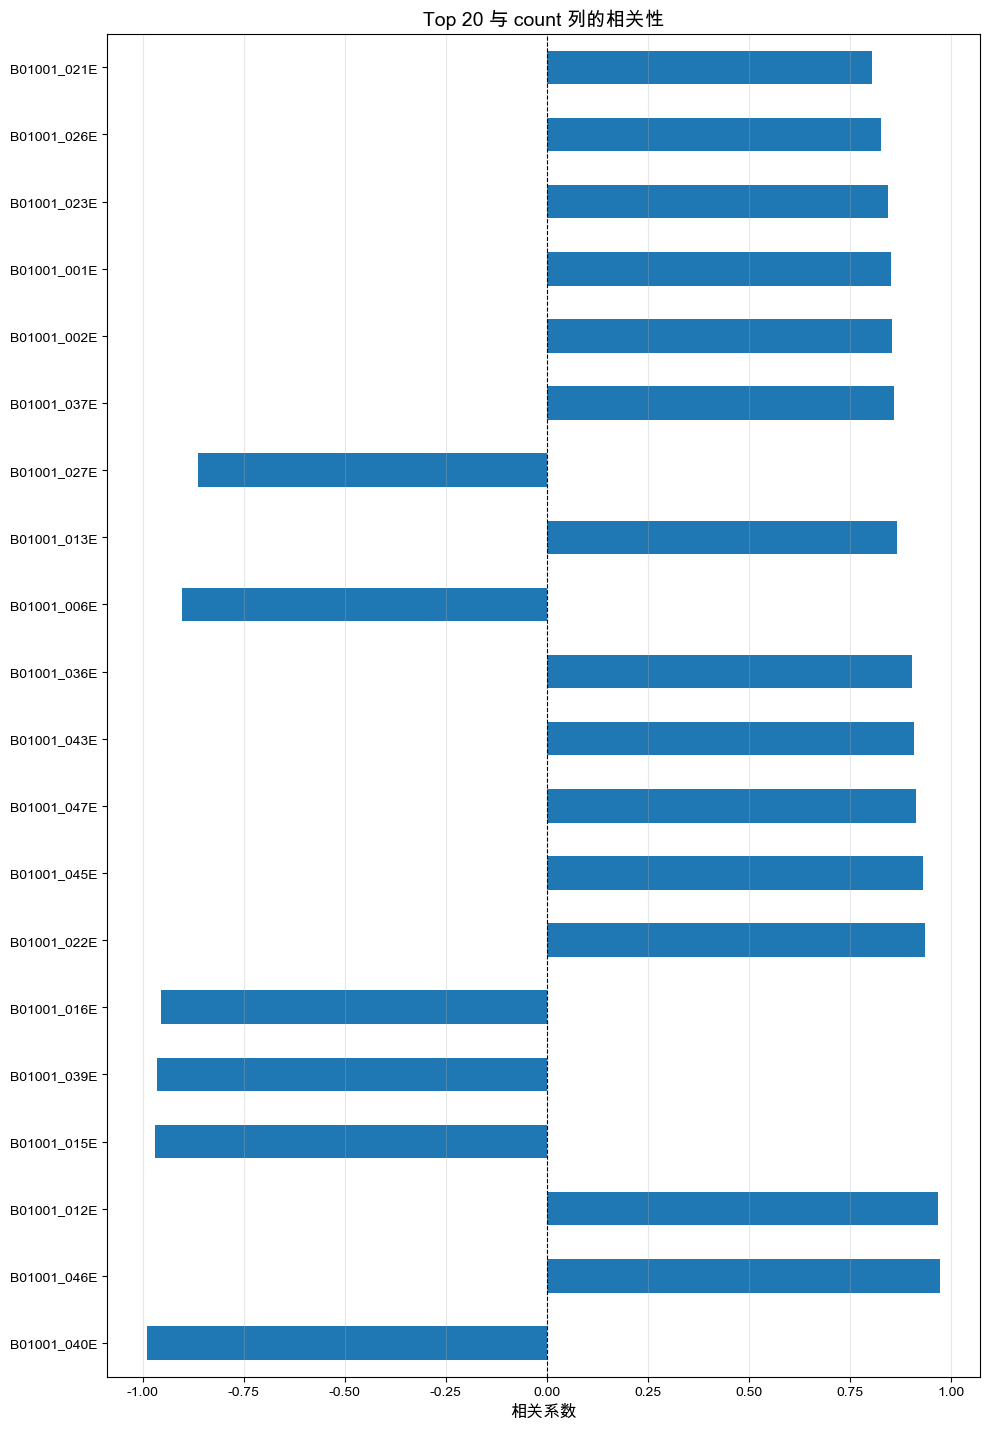

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 获取所有数值列
if 'count' in numeric_cols:
    numeric_cols.remove('count')

# 计算相关性矩阵
corr_with_count = df_pop_merge[numeric_cols + ['count']].corr()['count'].sort_values(ascending=False)

# 移除 count 自身
corr_with_count = corr_with_count.drop('count')

print("与 count 列的相关性（按绝对值排序）:")
print(corr_with_count.sort_values(key=abs, ascending=False).head(20))

# 可视化
plt.figure(figsize=(10, max(8, len(corr_with_count) * 0.3)))
corr_with_count.sort_values(key=abs, ascending=False).head(20).plot(kind='barh')
plt.xlabel('相关系数', fontsize=12)
plt.title('Top 20 与 count 列的相关性', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


In [92]:
corr_with_count

B01001_046E    0.973289
B01001_012E    0.968381
B01001_022E    0.935351
B01001_045E    0.930726
B01001_047E    0.913212
B01001_043E    0.909290
B01001_036E    0.903694
B01001_013E    0.867132
B01001_037E    0.859314
B01001_002E    0.854644
B01001_001E    0.851015
B01001_023E    0.844411
B01001_026E    0.826603
B01001_021E    0.805184
B01001_018E    0.774421
B01001_019E    0.742378
B01001_044E    0.742240
B01001_035E    0.722397
B01001_024E    0.683363
B01001_020E    0.547453
B01001_011E    0.533168
B01001_025E    0.403185
B01001_048E    0.345097
B01001_034E    0.275636
B01001_033E    0.192074
B01001_010E    0.138246
B01001_042E    0.067139
B01001_014E    0.035258
B01001_005E   -0.097888
B01001_028E   -0.103482
B01001_038E   -0.113548
B01001_008E   -0.135890
B01001_003E   -0.399220
B01001_030E   -0.506799
B01001_032E   -0.577761
B01001_009E   -0.589537
B01001_031E   -0.600395
B01001_017E   -0.615120
B01001_007E   -0.641564
B01001_004E   -0.709894
B01001_041E   -0.750244
B01001_029E   -0

## 2. 适用于短期预测的数据（1-2年）
天气

In [ ]:
# 温度数据：
df_weather = pd.read_csv('backend/data/1_demand_forecasting/maine_weather_1997_2025.csv')

In [ ]:
import joblib
import os

# 创建保存目录
model_dir = 'saved_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# ===== 保存 Prophet 模型 =====
if use_prophet:
    # 方法1: 使用 joblib（推荐，保存为 .pkl）
    prophet_path = os.path.join(model_dir, 'model_prophet.pkl')
    joblib.dump(model, prophet_path)
    print(f"Prophet 模型已保存到: {prophet_path}")

# ===== 保存 ARIMA 模型 =====
try:
    # ARIMA 模型必须使用 joblib 或 pickle（没有 save() 方法）
    arima_path = os.path.join(model_dir, 'model_arima.pkl')
    joblib.dump(fitted_model, arima_path)
    print(f"ARIMA 模型已保存到: {arima_path}")
except Exception as e:
    print(f"ARIMA 模型保存失败: {e}")

Prophet 模型已保存到: saved_models/model_prophet.pkl
ARIMA 模型已保存到: saved_models/model_arima.pkl


训练集: 114 个月 (2012-07-01 00:00:00 到 2021-12-01 00:00:00)
测试集: 12 个月 (2022-01-01 00:00:00 到 2022-12-01 00:00:00)
测试集月份数: 12


15:24:51 - cmdstanpy - INFO - Chain [1] start processing
15:24:51 - cmdstanpy - INFO - Chain [1] done processing


训练集: 114 个月 (2012-07-01 00:00:00 到 2021-12-01 00:00:00)
测试集: 12 个月 (2022-01-01 00:00:00 到 2022-12-01 00:00:00)
测试集月份数: 12
警告: 使用year_month匹配到 11 条数据，改用最后12行

测试集预测值数量: 11
测试集实际值数量: 11

Prophet 模型评估 (2022年):
MAE (平均绝对误差): 25.30
RMSE (均方根误差): 29.95
MAPE (平均绝对百分比误差): 18.85%


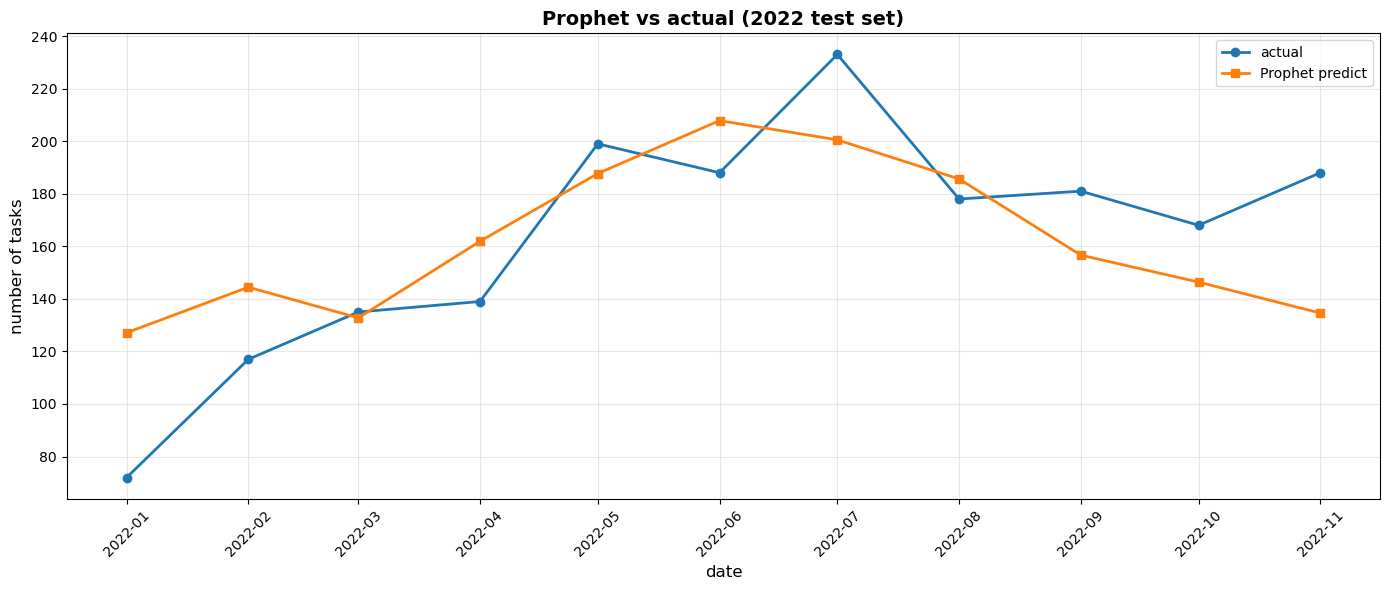

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



ARIMA 模型评估 (2022年):
MAE (平均绝对误差): 23.11
RMSE (均方根误差): 31.96
MAPE (平均绝对百分比误差): nan%


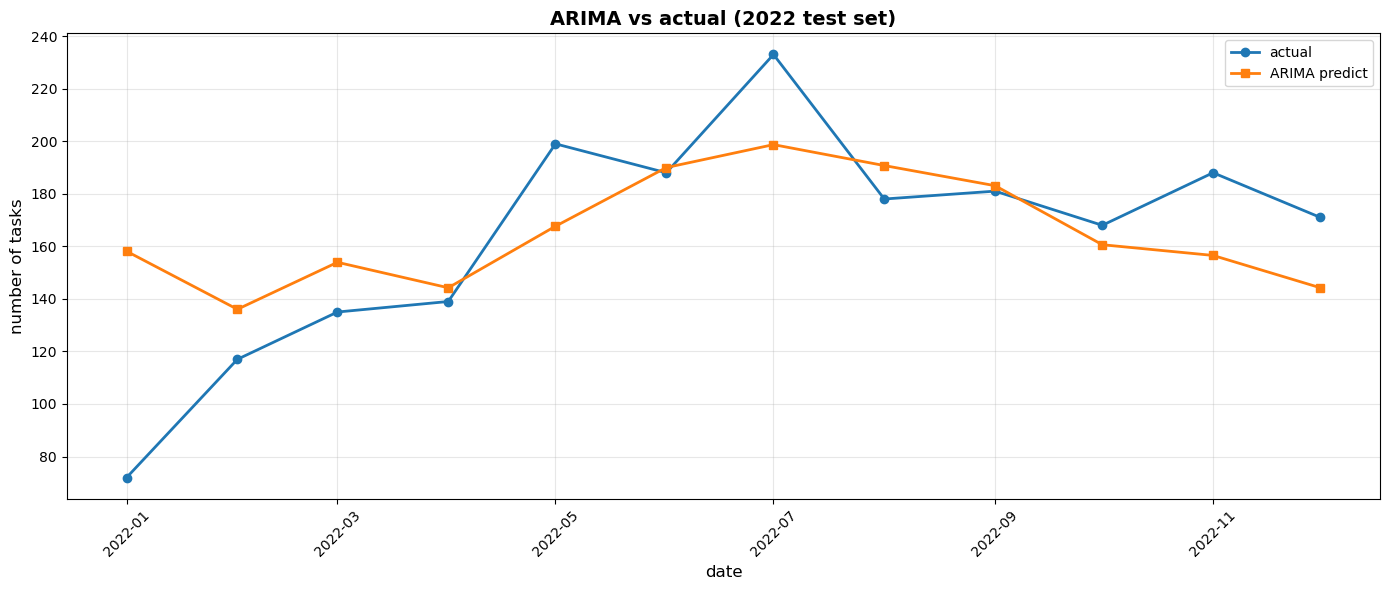

In [ ]:


from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# 将数据分为训练集和测试集（2022年作为测试集）
# 训练集：2012-2021年
# 测试集：2022年

train_data = monthly_data[monthly_data['date'].dt.year < 2022].copy()
test_data = monthly_data[monthly_data['date'].dt.year == 2022].copy()

print(f"训练集: {len(train_data)} 个月 ({train_data['date'].min()} 到 {train_data['date'].max()})")
print(f"测试集: {len(test_data)} 个月 ({test_data['date'].min()} 到 {test_data['date'].max()})")
print(f"测试集月份数: {len(test_data)}")

# 评估 Prophet 模型（如果可用）
if use_prophet:
    # 在训练集上训练
    train_prophet = train_data[['date', 'count']].copy()
    train_prophet.columns = ['ds', 'y']
    
    model_train = Prophet(yearly_seasonality=True, seasonality_mode='multiplicative')
    model_train.fit(train_prophet)
    
    # 预测测试集期间（2022年的12个月）
    # 计算需要预测的月份数
    months_to_predict = len(test_data)
    
    # 创建未来数据框
    future_test = model_train.make_future_dataframe(periods=months_to_predict, freq='M')
    forecast_test = model_train.predict(future_test)
    
    # 方法1：直接使用最后N行（N=测试集长度），因为Prophet会按顺序生成预测
    # 获取训练集的最后日期
    last_train_date = train_data['date'].max()
    
    # 从forecast_test中提取2022年的预测值
    # 将日期转换为年月格式进行比较
    forecast_test['year_month'] = forecast_test['ds'].dt.to_period('M')
    test_data['year_month'] = test_data['date'].dt.to_period('M')
    
    # 匹配2022年的数据
    test_forecast_df = forecast_test[forecast_test['year_month'].isin(test_data['year_month'])].copy()
    
    # 如果还是匹配不到，使用最后N行
    if len(test_forecast_df) == 0 or len(test_forecast_df) != len(test_data):
        print(f"警告: 使用year_month匹配到 {len(test_forecast_df)} 条数据，改用最后{months_to_predict}行")
        test_forecast_df = forecast_test[['ds', 'yhat']].tail(months_to_predict).copy()
        test_forecast_df['year_month'] = test_forecast_df['ds'].dt.to_period('M')
    
    # 合并数据，确保顺序一致
    test_data_with_forecast = test_data.merge(
        test_forecast_df[['year_month', 'yhat']],
        on='year_month',
        how='inner'
    )
    
    # 如果合并后数据为空，尝试更宽松的匹配
    if len(test_data_with_forecast) == 0:
        print("警告: 合并失败，尝试直接使用索引匹配")
        # 直接使用最后N行，并手动对齐
        test_forecast_values = forecast_test['yhat'].tail(months_to_predict).values
        test_actual_values = test_data['count'].values
        
        # 确保长度一致
        min_len = min(len(test_forecast_values), len(test_actual_values))
        test_forecast = test_forecast_values[:min_len]
        test_actual = test_actual_values[:min_len]
    else:
        # 按日期排序
        test_data_with_forecast = test_data_with_forecast.sort_values('date')
        
        # 提取预测值和实际值
        test_forecast = test_data_with_forecast['yhat'].values
        test_actual = test_data_with_forecast['count'].values
    
    print(f"\n测试集预测值数量: {len(test_forecast)}")
    print(f"测试集实际值数量: {len(test_actual)}")
    
    # 最终检查：确保有数据且长度一致
    if len(test_forecast) == 0 or len(test_actual) == 0:
        print("错误: 无法匹配预测值和实际值，请检查日期格式")
        print(f"Forecast dates: {forecast_test['ds'].tail(15).tolist()}")
        print(f"Test dates: {test_data['date'].tolist()}")
    else:
        # 确保长度一致
        min_len = min(len(test_forecast), len(test_actual))
        test_forecast = test_forecast[:min_len]
        test_actual = test_actual[:min_len]
        
        # 计算评估指标
        mae_prophet = mean_absolute_error(test_actual, test_forecast)
        rmse_prophet = math.sqrt(mean_squared_error(test_actual, test_forecast))
        mape_prophet = np.mean(np.abs((test_actual - test_forecast) / test_actual)) * 100
        
        print("\nProphet 模型评估 (2022年):")
        print(f"MAE (平均绝对误差): {mae_prophet:.2f}")
        print(f"RMSE (均方根误差): {rmse_prophet:.2f}")
        print(f"MAPE (平均绝对百分比误差): {mape_prophet:.2f}%")
        
        # 可视化预测 vs 实际
        test_dates = test_data_with_forecast['date'].values[:min_len] if 'test_data_with_forecast' in locals() and len(test_data_with_forecast) > 0 else test_data['date'].values[:min_len]
        
        plt.figure(figsize=(14, 6))
        plt.plot(test_dates, test_actual, 'o-', label='actual', linewidth=2, markersize=6)
        plt.plot(test_dates, test_forecast, 's-', label='Prophet predict', linewidth=2, markersize=6)
        plt.title('Prophet vs actual (2022 test set)', fontsize=14, fontweight='bold')
        plt.xlabel('date', fontsize=12)
        plt.ylabel('number of tasks', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# 评估 ARIMA 模型
try:
    train_ts = train_data.set_index('date')['count']
    model_arima_train = ARIMA(train_ts, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    fitted_arima_train = model_arima_train.fit()
    
    # 预测测试集（2022年的12个月）
    forecast_arima_test = fitted_arima_train.forecast(steps=len(test_data))
    
    mae_arima = mean_absolute_error(test_data['count'], forecast_arima_test)
    rmse_arima = math.sqrt(mean_squared_error(test_data['count'], forecast_arima_test))
    mape_arima = np.mean(np.abs((test_data['count'] - forecast_arima_test) / test_data['count'])) * 100
    
    print("\nARIMA 模型评估 (2022年):")
    print(f"MAE (平均绝对误差): {mae_arima:.2f}")
    print(f"RMSE (均方根误差): {rmse_arima:.2f}")
    print(f"MAPE (平均绝对百分比误差): {mape_arima:.2f}%")
    
    # 可视化预测 vs 实际
    plt.figure(figsize=(14, 6))
    plt.plot(test_data['date'], test_data['count'], 'o-', label='actual', linewidth=2, markersize=6)
    plt.plot(test_data['date'], forecast_arima_test.values, 's-', label='ARIMA predict', linewidth=2, markersize=6)
    plt.title('ARIMA vs actual (2022 test set)', fontsize=14, fontweight='bold')
    plt.xlabel('date', fontsize=12)
    plt.ylabel('number of tasks', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"ARIMA 评估出错: {e}")
    import traceback
    traceback.print_exc()


In [21]:
monthly_data

,date,count
0,2012-07-01,136
1,2012-08-01,140
2,2012-09-01,105
3,2012-10-01,74
4,2012-11-01,93
...,...,...
133,2023-08-01,183
134,2023-09-01,186
135,2023-10-01,166
136,2023-11-01,203


In [29]:
df_2018 = monthly_data[monthly_data['date'].dt.year == 2018]
df_2020 = monthly_data[monthly_data['date'].dt.year == 2020]
df_2021 = monthly_data[monthly_data['date'].dt.year == 2021]
df_2022 = monthly_data[monthly_data['date'].dt.year == 2022]
df_2023 = monthly_data[monthly_data['date'].dt.year == 2023]

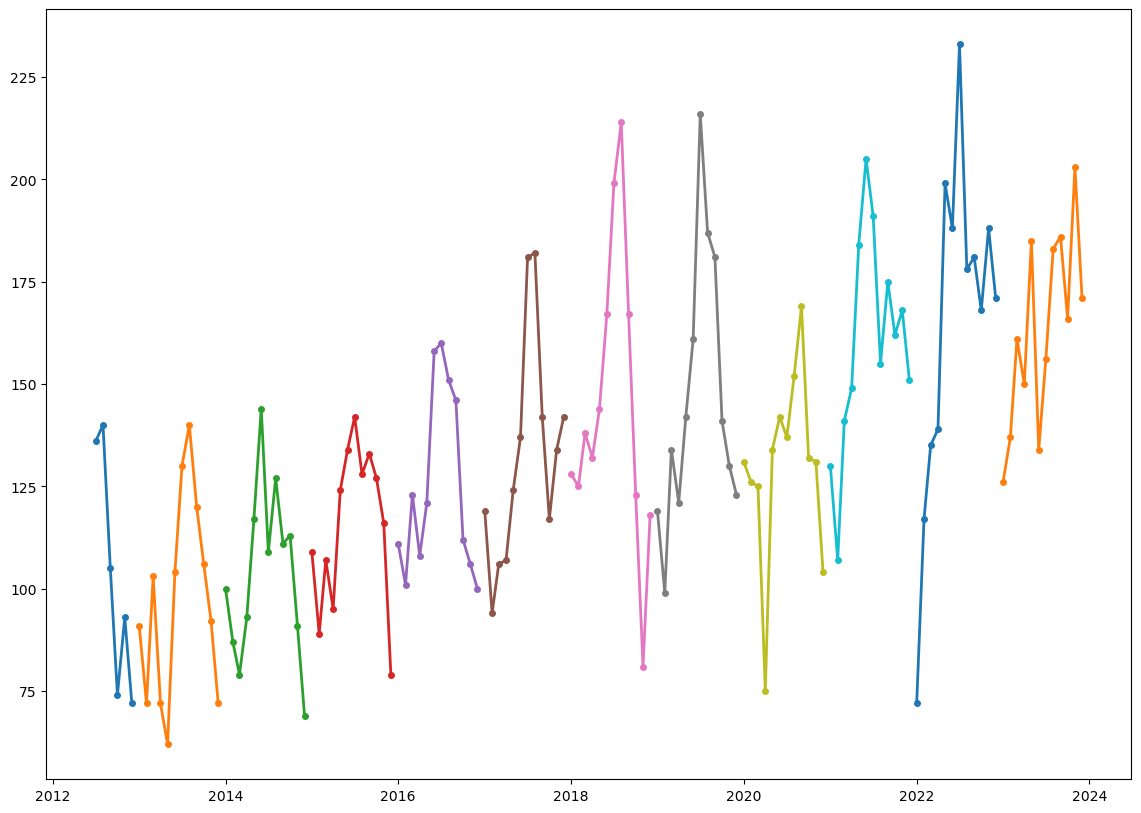

In [ ]:
plt.figure(figsize=(14, 10))
for year in range(2012, 2024):
    df_year = monthly_data[monthly_data['date'].dt.year == year]
    plt.plot(df_year['date'], df_year['count'], marker='o', linewidth=2, markersize=4)
plt.show()

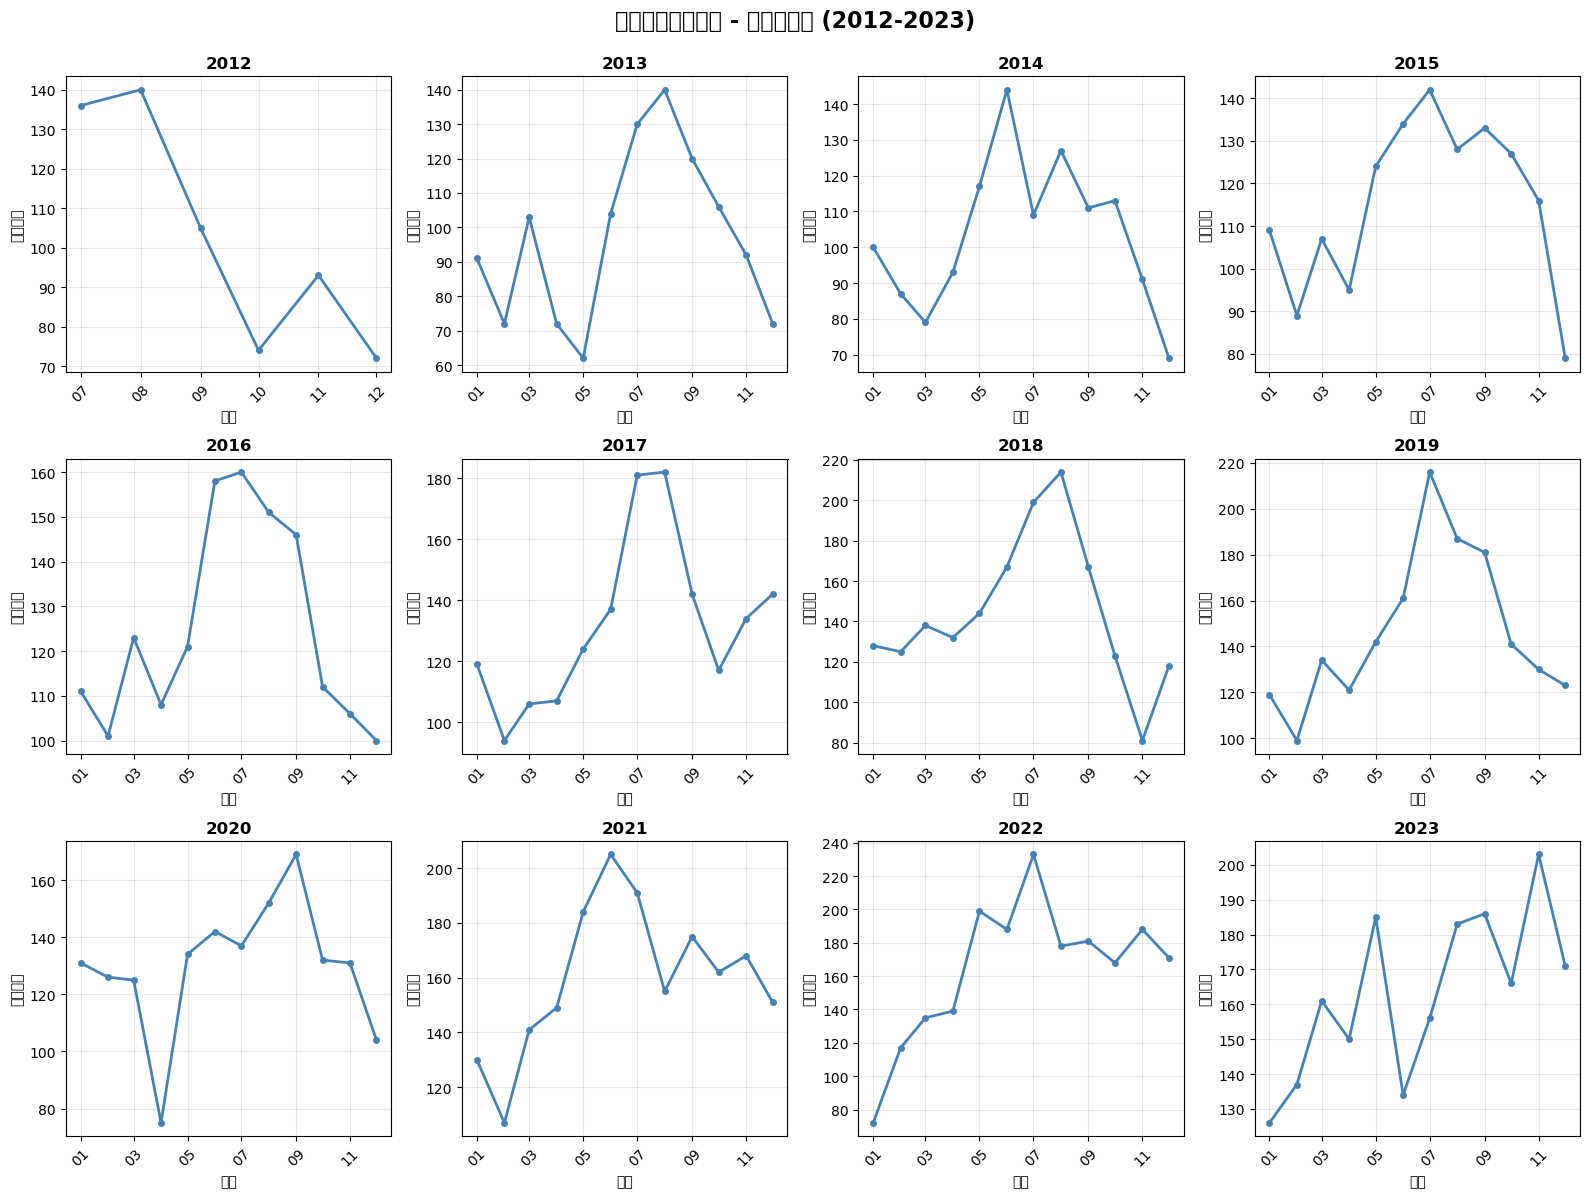

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 计算需要的子图布局（3行4列，共12年）
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle('月度任务数量趋势 - 按年度分图 (2012-2023)', fontsize=16, fontweight='bold', y=0.995)

# 将 axes 展平为一维数组，方便遍历
axes = axes.flatten()

years = range(2012, 2024)
for idx, year in enumerate(years):
    df_year = monthly_data[monthly_data['date'].dt.year == year]
    
    if len(df_year) > 0:
        axes[idx].plot(df_year['date'], df_year['count'], marker='o', linewidth=2, markersize=4, color='steelblue')
        axes[idx].set_title(f'{year}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('月份', fontsize=10)
        axes[idx].set_ylabel('任务数量', fontsize=10)
        axes[idx].grid(True, alpha=0.3)
        axes[idx].tick_params(axis='x', rotation=45)
        
        # 设置 x 轴格式为月份
        axes[idx].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%m'))
    else:
        axes[idx].text(0.5, 0.5, f'{year}年\n无数据', ha='center', va='center', transform=axes[idx].transAxes)
        axes[idx].set_title(f'{year}年', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
import requests
years = range(2012, 2024)  # 2012 到 2023 inclusive
API_KEY = '44b467ab29b78c3c2b06b200a838a102c5a11bfa'
results = []
for yr in years:
    url = f"https://api.census.gov/data/{yr}/acs/acs1?get=NAME,B01003_001E&for=state:23"
    resp = requests.get(url)
    if resp.status_code == 200:
        data = resp.json()
        # 第一行是字段名，再之后是数据行
        results.append((yr, data))
    else:
        if yr == 2020:
            results.append((2020,[['NAME', 'B01003_001E', 'state'], ['Maine', '1362359', '23']]))
        print(f"Year {yr} failed: {resp.status_code}")


Year 2020 failed: 404


In [73]:
#把results存入csv
df = pd.DataFrame(results, columns=['year', 'population'])
df.to_csv('population_data.csv', index=False)


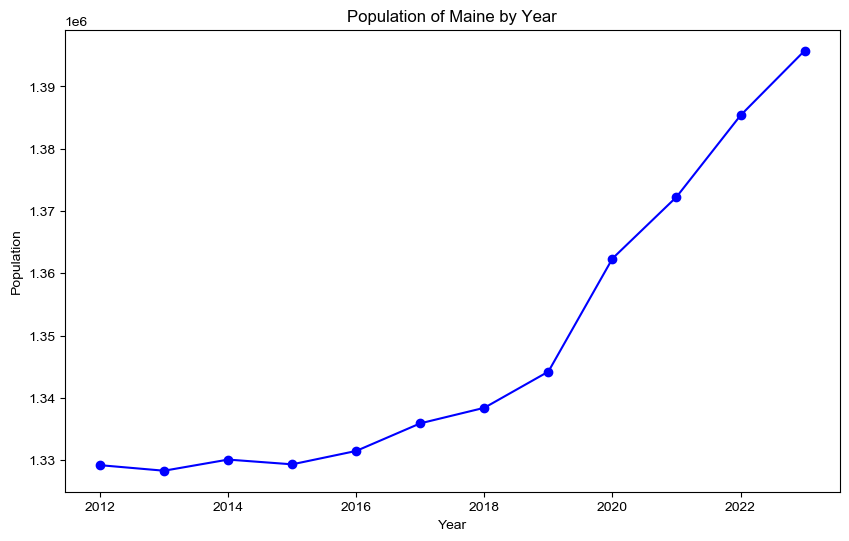

In [101]:
# 把results放入dict
results_dict = {}
for yr, data in results:
    results_dict[int(yr)] = int(data[1][1])
# 把results_dict画折线图
plt.figure(figsize=(10, 6))
plt.plot(years, [results_dict[yr] for yr in years], marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel('Population')
plt.title('Population of Maine by Year')
plt.show()



美国人口数据:
        date  population_millions
0 2012-07-01         1.328747e+06
1 2012-08-01         1.328673e+06
2 2012-09-01         1.328599e+06
3 2012-10-01         1.328524e+06
4 2012-11-01         1.328450e+06
5 2012-12-01         1.328376e+06
6 2013-01-01         1.328302e+06
7 2013-02-01         1.328451e+06
8 2013-03-01         1.328600e+06
9 2013-04-01         1.328749e+06

人口数据范围: 2012-07-01 00:00:00 到 2023-12-01 00:00:00
人口范围: 1328302.00 - 1394856.83 百万

合并后数据:
总月份数: 138
        date  count  population_millions
0 2012-07-01    136         1.328747e+06
1 2012-08-01    140         1.328673e+06
2 2012-09-01    105         1.328599e+06
3 2012-10-01     74         1.328524e+06
4 2012-11-01     93         1.328450e+06
5 2012-12-01     72         1.328376e+06
6 2013-01-01     91         1.328302e+06
7 2013-02-01     72         1.328451e+06
8 2013-03-01    103         1.328600e+06
9 2013-04-01     72         1.328749e+06
          date  count  population_millions
128 2023-03-01    161 

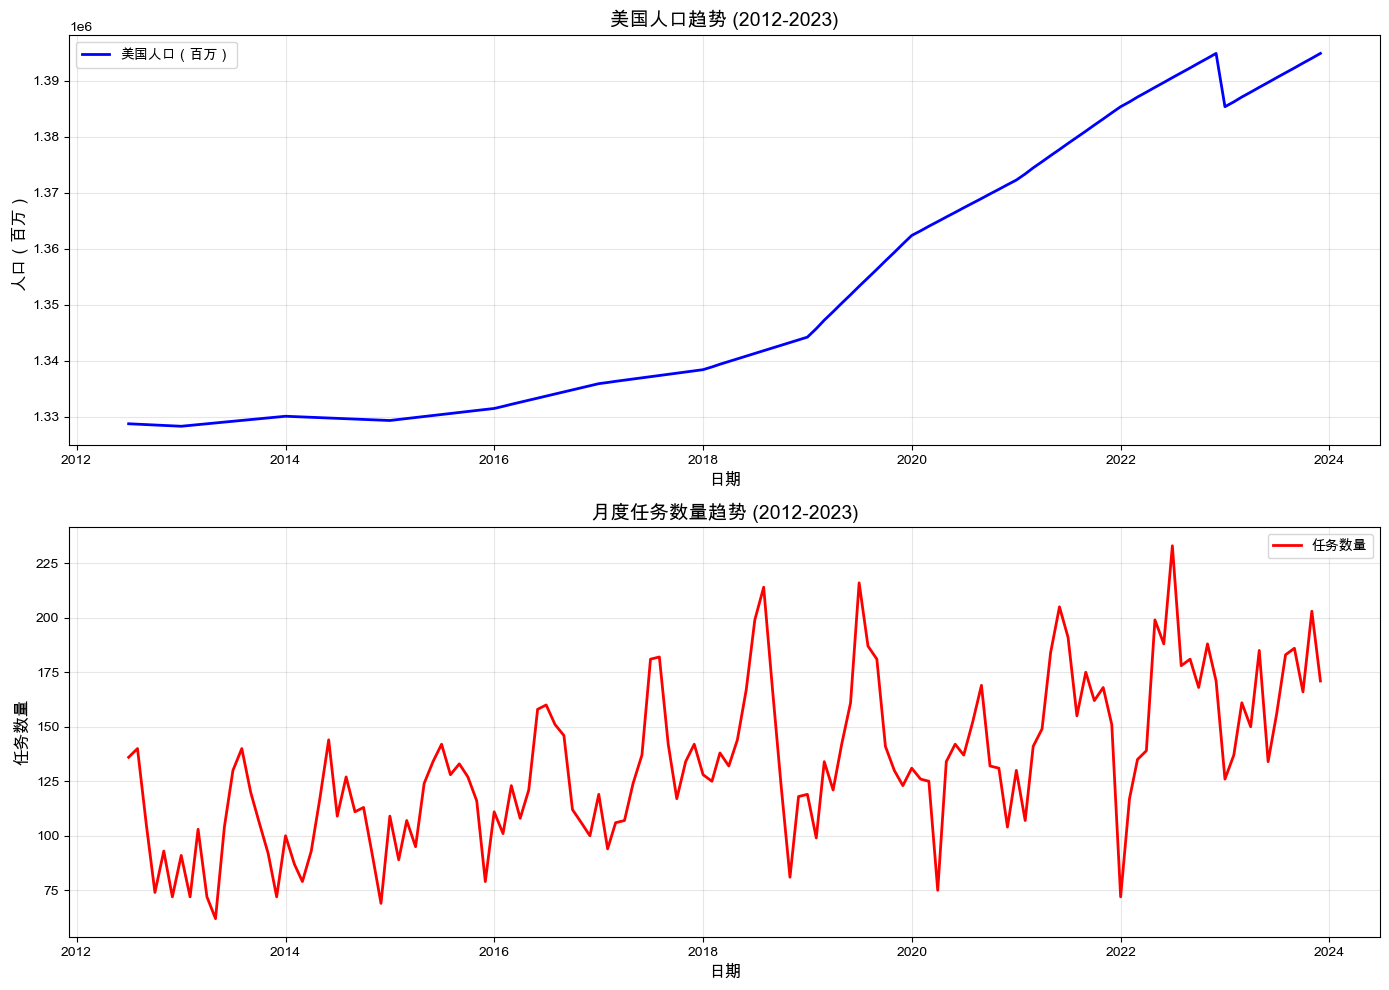

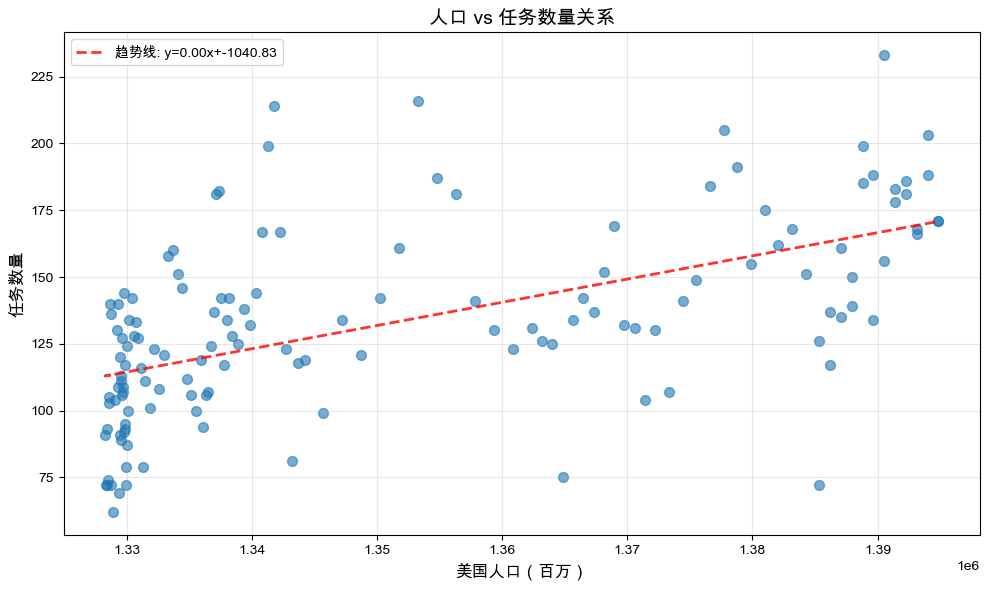


人口与任务数量的相关系数: 0.5760


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')


def get_us_population_data():
    population_data = results_dict
    
    # 创建年度人口DataFrame
    pop_df = pd.DataFrame(list(population_data.items()), columns=['year', 'population_millions'])
    
    # 为每月插值人口数据（假设线性增长）
    monthly_pop = []
    for year in range(2012, 2024):
        if year == 2012:
            # 2012年使用2012和2013年的平均值作为起点
            start_pop = population_data[2012]
            end_pop = population_data[2013]
        elif year == 2023:
            # 2023年使用2022和2023年的数据
            start_pop = population_data[2022]
            end_pop = population_data[2023]
        else:
            start_pop = population_data[year]
            end_pop = population_data[year + 1]
        
        # 计算每月的人口增长
        monthly_growth = (end_pop - start_pop) / 12
        
        # 生成12个月的数据
        for month in range(1, 13):
            if year == 2012 and month < 7:
                continue  # 数据从2012年7月开始
            if year == 2023 and month > 12:
                break
            pop_value = start_pop + (month - 1) * monthly_growth
            monthly_pop.append({
                'year': year,
                'month': month,
                'population_millions': pop_value
            })
    
    monthly_pop_df = pd.DataFrame(monthly_pop)
    monthly_pop_df['date'] = pd.to_datetime(monthly_pop_df[['year', 'month']].assign(day=1))
    
    return monthly_pop_df[['date', 'population_millions']]

# 获取人口数据
population_df = get_us_population_data()
print("美国人口数据:")
print(population_df.head(10))
print(f"\n人口数据范围: {population_df['date'].min()} 到 {population_df['date'].max()}")
print(f"人口范围: {population_df['population_millions'].min():.2f} - {population_df['population_millions'].max():.2f} 百万")

# 合并人口数据和任务数据
merged_data = monthly_data.merge(
    population_df,
    on='date',
    how='inner'
)

print(f"\n合并后数据:")
print(f"总月份数: {len(merged_data)}")
print(merged_data.head(10))
print(merged_data.tail(10))

# 可视化人口和任务数量的关系
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# 上图：人口趋势
axes[0].plot(merged_data['date'], merged_data['population_millions'], 'b-', linewidth=2, label='美国人口（百万）')
axes[0].set_title('美国人口趋势 (2012-2023)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('日期', fontsize=12)
axes[0].set_ylabel('人口（百万）', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# 下图：任务数量趋势
axes[1].plot(merged_data['date'], merged_data['count'], 'r-', linewidth=2, label='任务数量')
axes[1].set_title('月度任务数量趋势 (2012-2023)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('日期', fontsize=12)
axes[1].set_ylabel('任务数量', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

# 散点图：人口 vs 任务数量
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['population_millions'], merged_data['count'], alpha=0.6, s=50)
plt.xlabel('美国人口（百万）', fontsize=12)
plt.ylabel('任务数量', fontsize=12)
plt.title('人口 vs 任务数量关系', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# 添加趋势线
z = np.polyfit(merged_data['population_millions'], merged_data['count'], 1)
p = np.poly1d(z)
plt.plot(merged_data['population_millions'], p(merged_data['population_millions']), "r--", alpha=0.8, linewidth=2, label=f'趋势线: y={z[0]:.2f}x+{z[1]:.2f}')
plt.legend()
plt.tight_layout()
plt.show()

# 计算相关系数
correlation = merged_data['population_millions'].corr(merged_data['count'])
print(f"\n人口与任务数量的相关系数: {correlation:.4f}")

In [52]:
df.groupby('PU State').size()

PU State
Connecticut          2
Georgia              1
Maine            17295
Massachusetts       83
New Brunswick        7
New Hampshire      968
Nova Scotia          1
Pennsylvania         2
Quebec               2
Vermont             13
maine                8
dtype: int64

In [106]:
y_test

array([ 72, 117, 135, 139, 199, 188, 233, 178, 181, 168, 188, 171])

训练集: 114 个月 (2012-07-01 00:00:00 到 2021-12-01 00:00:00)
测试集: 12 个月 (2022-01-01 00:00:00 到 2022-12-01 00:00:00)

模型1: 线性回归

训练集评估:
  MAE: 20.81
  RMSE: 26.74
  R²: 0.3203

测试集评估 (2022年):
  MAE: 33.33
  RMSE: 40.28
  R²: 0.0182

模型系数:
  斜率: 3.37 (每增加100万人，任务数增加 336.58)
  截距: -967.13

模型2: 随机森林回归

训练集评估:
  MAE: 10.76
  RMSE: 14.43
  R²: 0.8022

测试集评估 (2022年):
  MAE: 34.83
  RMSE: 41.40
  R²: -0.0371


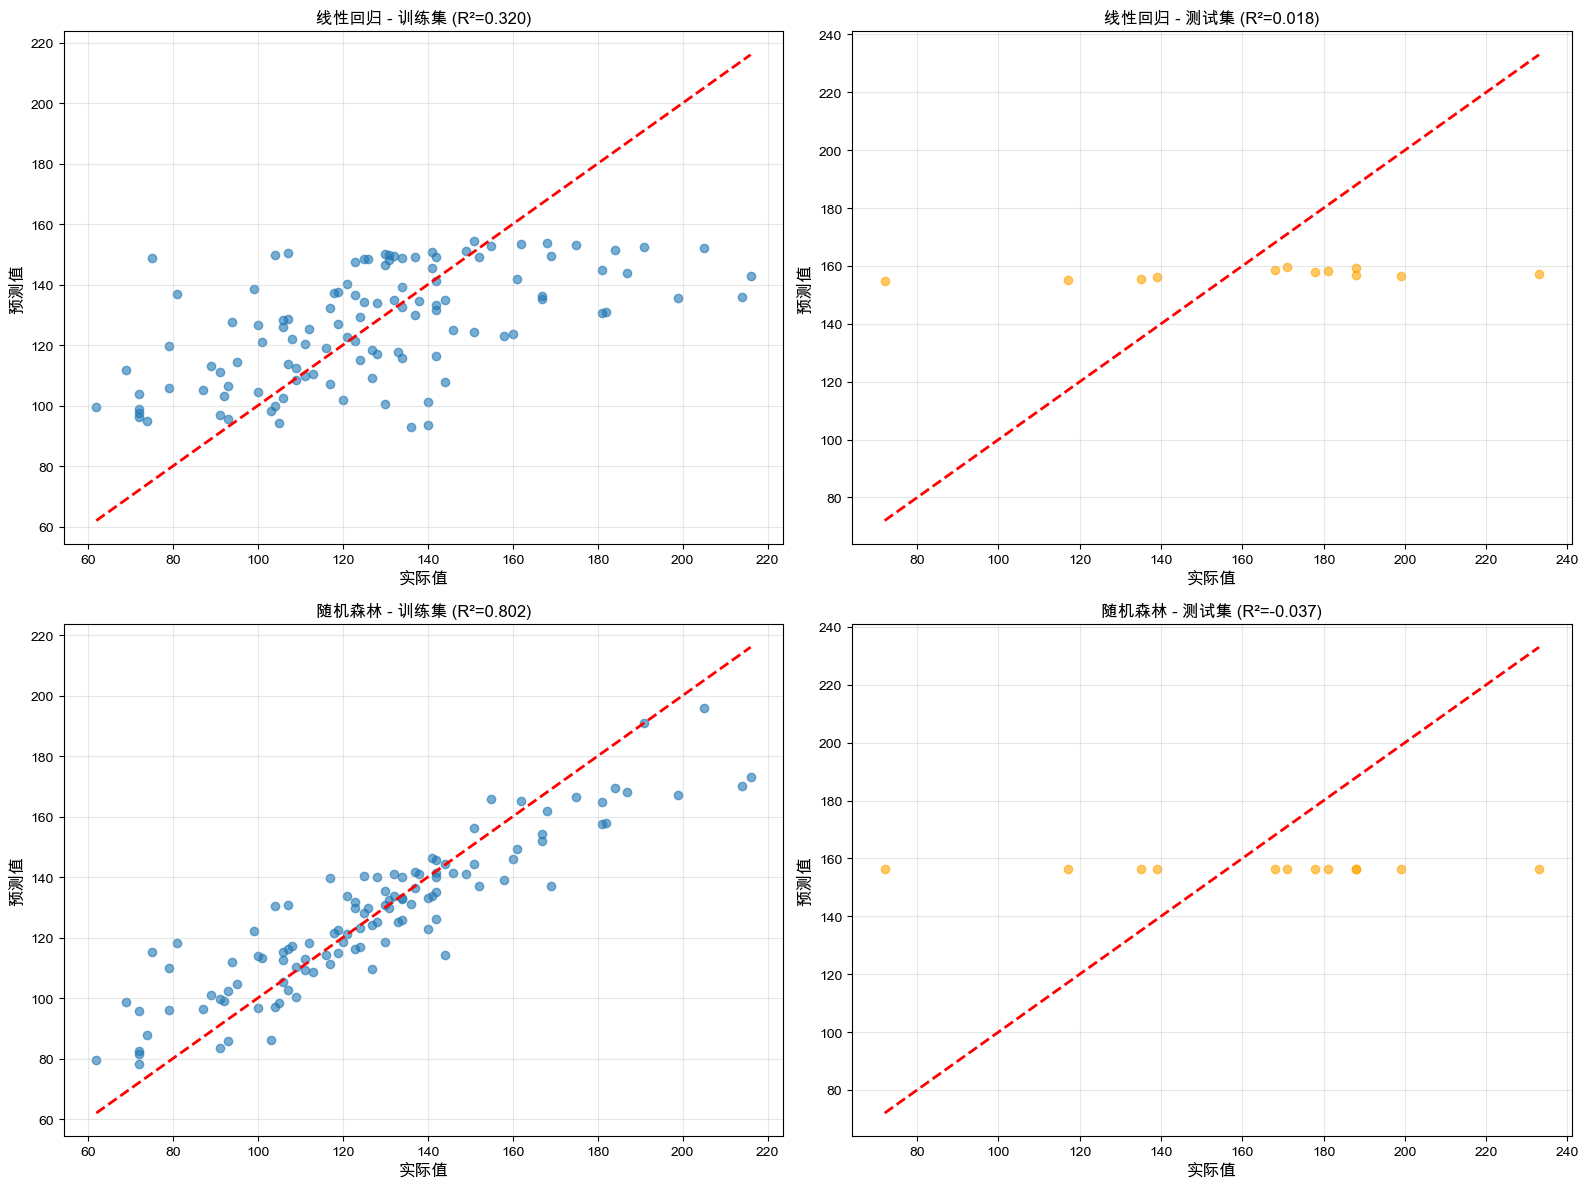

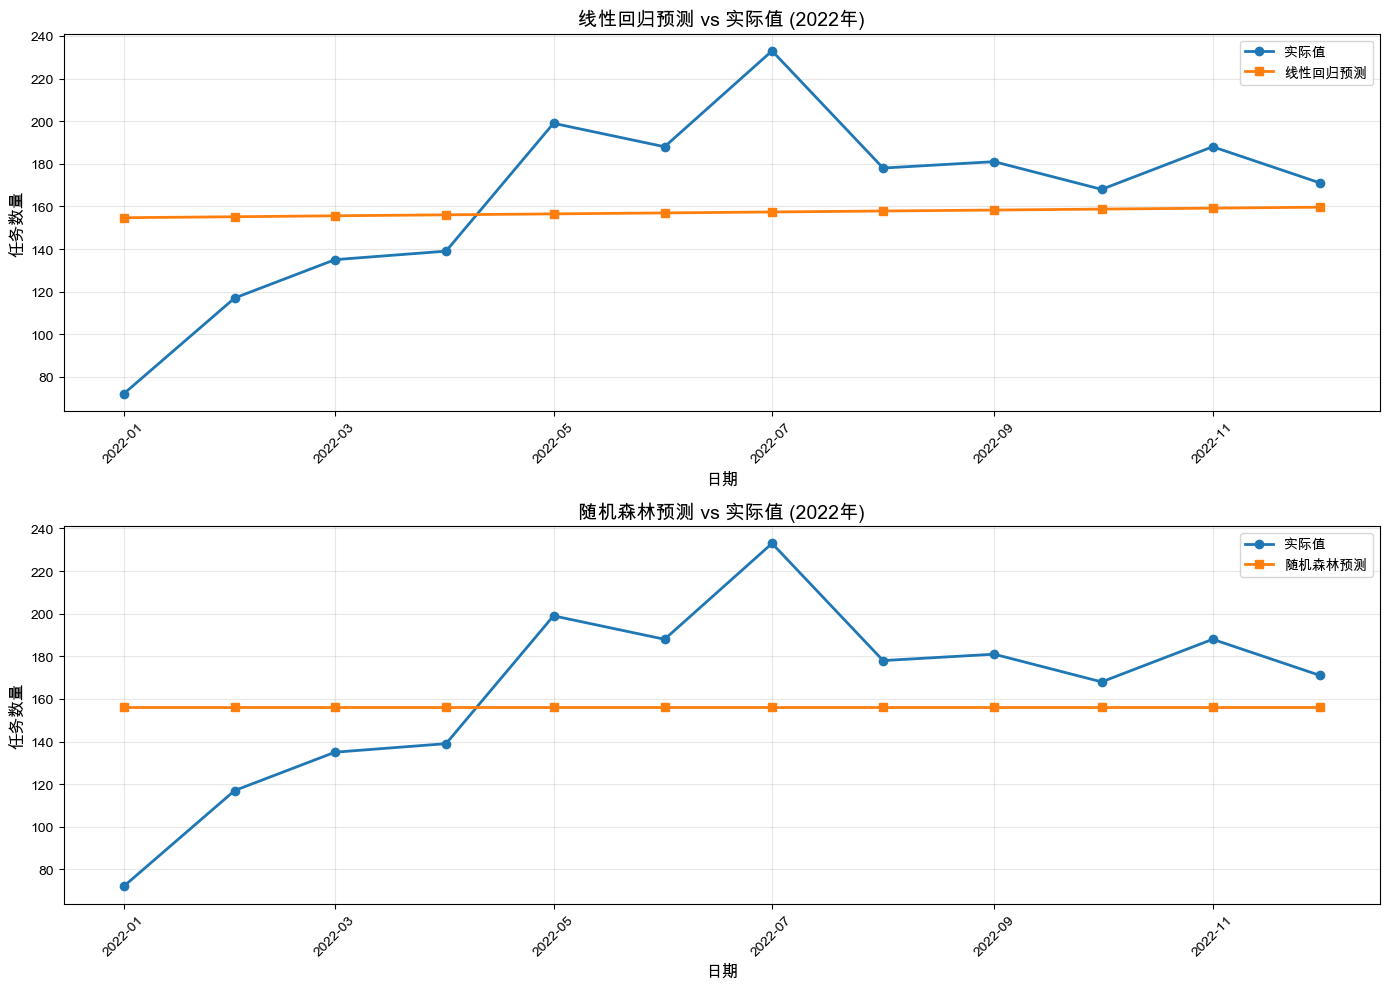

In [ ]:
from sklearn.preprocessing import StandardScaler

# 准备特征和目标变量
X = merged_data[['population_millions']].values
y = merged_data['count'].values

# 划分训练集和测试集（使用2022年作为测试集）
train_mask = merged_data['date'].dt.year < 2022
test_mask = merged_data['date'].dt.year == 2022

X_train = X[train_mask]
y_train = y[train_mask]
X_test = X[test_mask]
y_test = y[test_mask]

print(f"训练集: {len(X_train)} 个月 ({merged_data[train_mask]['date'].min()} 到 {merged_data[train_mask]['date'].max()})")
print(f"测试集: {len(X_test)} 个月 ({merged_data[test_mask]['date'].min()} 到 {merged_data[test_mask]['date'].max()})")

# 标准化特征（可选，对于线性回归通常不需要，但有助于比较）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 模型1: 线性回归
print("\n" + "="*60)
print("模型1: 线性回归")
print("="*60)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# 预测
y_train_pred_lr = lr_model.predict(X_train)
y_test_pred_lr = lr_model.predict(X_test)

# 评估
train_mae_lr = mean_absolute_error(y_train, y_train_pred_lr)
train_rmse_lr = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))
train_r2_lr = r2_score(y_train, y_train_pred_lr)

test_mae_lr = mean_absolute_error(y_test, y_test_pred_lr)
test_rmse_lr = np.sqrt(mean_squared_error(y_test, y_test_pred_lr))
test_r2_lr = r2_score(y_test, y_test_pred_lr)

print(f"\n训练集评估:")
print(f"  MAE: {train_mae_lr:.2f}")
print(f"  RMSE: {train_rmse_lr:.2f}")
print(f"  R²: {train_r2_lr:.4f}")

print(f"\n测试集评估 (2022年):")
print(f"  MAE: {test_mae_lr:.2f}")
print(f"  RMSE: {test_rmse_lr:.2f}")
print(f"  R²: {test_r2_lr:.4f}")

print(f"\n模型系数:")
print(f"  斜率: {lr_model.coef_[0]:.2f} (每增加100万人，任务数增加 {lr_model.coef_[0]*100:.2f})")
print(f"  截距: {lr_model.intercept_:.2f}")

# 模型2: 随机森林回归
print("\n" + "="*60)
print("模型2: 随机森林回归")
print("="*60)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5)
rf_model.fit(X_train, y_train)

# 预测
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# 评估
train_mae_rf = mean_absolute_error(y_train, y_train_pred_rf)
train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
train_r2_rf = r2_score(y_train, y_train_pred_rf)

test_mae_rf = mean_absolute_error(y_test, y_test_pred_rf)
test_rmse_rf = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
test_r2_rf = r2_score(y_test, y_test_pred_rf)

print(f"\n训练集评估:")
print(f"  MAE: {train_mae_rf:.2f}")
print(f"  RMSE: {train_rmse_rf:.2f}")
print(f"  R²: {train_r2_rf:.4f}")

print(f"\n测试集评估 (2022年):")
print(f"  MAE: {test_mae_rf:.2f}")
print(f"  RMSE: {test_rmse_rf:.2f}")
print(f"  R²: {test_r2_rf:.4f}")

# 可视化预测结果
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 线性回归 - 训练集
axes[0, 0].scatter(y_train, y_train_pred_lr, alpha=0.6)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('实际值', fontsize=12)
axes[0, 0].set_ylabel('预测值', fontsize=12)
axes[0, 0].set_title(f'线性回归 - 训练集 (R²={train_r2_lr:.3f})', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 线性回归 - 测试集
axes[0, 1].scatter(y_test, y_test_pred_lr, alpha=0.6, color='orange')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('实际值', fontsize=12)
axes[0, 1].set_ylabel('预测值', fontsize=12)
axes[0, 1].set_title(f'线性回归 - 测试集 (R²={test_r2_lr:.3f})', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 随机森林 - 训练集
axes[1, 0].scatter(y_train, y_train_pred_rf, alpha=0.6)
axes[1, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[1, 0].set_xlabel('实际值', fontsize=12)
axes[1, 0].set_ylabel('预测值', fontsize=12)
axes[1, 0].set_title(f'随机森林 - 训练集 (R²={train_r2_rf:.3f})', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 随机森林 - 测试集
axes[1, 1].scatter(y_test, y_test_pred_rf, alpha=0.6, color='orange')
axes[1, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1, 1].set_xlabel('实际值', fontsize=12)
axes[1, 1].set_ylabel('预测值', fontsize=12)
axes[1, 1].set_title(f'随机森林 - 测试集 (R²={test_r2_rf:.3f})', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 时间序列可视化
test_dates = merged_data[test_mask]['date'].values

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# 线性回归预测
axes[0].plot(test_dates, y_test, 'o-', label='实际值', linewidth=2, markersize=6)
axes[0].plot(test_dates, y_test_pred_lr, 's-', label='线性回归预测', linewidth=2, markersize=6)
axes[0].set_title('线性回归预测 vs 实际值 (2022年)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('日期', fontsize=12)
axes[0].set_ylabel('任务数量', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# 随机森林预测
axes[1].plot(test_dates, y_test, 'o-', label='实际值', linewidth=2, markersize=6)
axes[1].plot(test_dates, y_test_pred_rf, 's-', label='随机森林预测', linewidth=2, markersize=6)
axes[1].set_title('随机森林预测 vs 实际值 (2022年)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('日期', fontsize=12)
axes[1].set_ylabel('任务数量', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

array([ 72, 117, 135, 139, 199, 188, 233, 178, 181, 168, 188, 171])

In [74]:
df_master = pd.read_csv('refer data/FlightTransportsMaster.csv')

In [76]:
df_master

,tdate,putime,disptime,enrtime,atstime,tratime,atdtime,yearwithrc,Call Type,veh,...,Charts Transports FY 13 14_Receiving,Receiving Hospital Unit,Rec City,Rec State,Age Range,Weight,Medical,Outcome,Transported,TASC Primary Asset
0,08/1/2021,8/1/2021 20:02:00,8/1/2021 20:03:22,8/1/2021 21:27:09,8/1/2021 22:05:23,8/2/2021 00:30:08,8/2/2021 01:12:54,21-30137,LOM FIXED WING,LF3,...,Eastern Maine Medical Center,Neonatal ICU,Bangor,Maine,0-1,3.5,Neonatal,Transported Patient,Yes,LF3
1,08/3/2021,8/3/2021 11:41:37,8/3/2021 11:44:21,8/3/2021 12:16:21,8/3/2021 13:04:20,8/3/2021 14:39:29,8/3/2021 15:28:14,21-30389,NL Neonate,NEO49,...,Eastern Maine Medical Center,Neonatal ICU,Bangor,Maine,0-1,2.7,Neonatal,Transported Patient,Yes,neoGround
2,08/7/2021,8/7/2021 03:08:01,8/7/2021 03:10:21,8/7/2021 03:43:33,8/7/2021 04:31:42,8/7/2021 06:29:05,8/7/2021 07:16:19,21-30971,NL Neonate,NEO49,...,Eastern Maine Medical Center,Neonatal ICU,Bangor,Maine,0-1,4.7,Neonatal,Transported Patient,Yes,LF1
3,08/10/2021,8/10/2021 10:24:01,8/10/2021 10:24:27,8/10/2021 11:05:06,8/10/2021 11:57:35,8/10/2021 13:14:48,8/10/2021 14:03:45,21-31349,LOM INTERFACILITY,LF1,...,Eastern Maine Medical Center,Neonatal ICU,Bangor,Maine,0-1,2.6,Neonatal,Transported Patient,Yes,LF1
4,08/12/2021,8/12/2021 09:22:00,8/12/2021 09:22:28,8/12/2021 09:54:00,8/12/2021 11:09:51,8/12/2021 12:29:59,8/12/2021 13:40:39,21-31660,NL Neonate,NEO49,...,Eastern Maine Medical Center,Neonatal ICU,Bangor,Maine,0-1,4.4,Neonatal,Transported Patient,Yes,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7817,07/16/2024,7/16/2024 14:45:58,7/16/2024 14:46:23,7/16/2024 15:07:02,7/16/2024 15:19:10,7/16/2024 15:52:39,7/16/2024 16:04:29,24-36218,LOM SCENE,LF4,...,MaineHealth Maine Medical Center Portland,NaN,Portland,ME,44,176.4,Trauma,Transport by This EMS Unit (This Crew Only),Yes,LF4
7818,07/31/2024,7/31/2024 14:14:07,7/31/2024 14:15:15,7/31/2024 14:20:48,7/31/2024 14:40:55,7/31/2024 14:57:44,7/31/2024 15:14:51,24-39189,LOM CCT GROUND - NO BILL,LF10,...,EASTERN MAINE MEDICAL CENTER,NaN,Bangor,ME,32,242.5,Trauma,"Transport by Another EMS Unit, with a Member o...",Yes,LF1
7819,8/31/2024,8/31/2024 18:08:48,8/31/2024 18:09:35,8/31/2024 18:20:00,8/31/2024 18:38:01,8/31/2024 19:08:40,8/31/2024 19:23:59,24-45343,LOM SCENE,LF2,...,EASTERN MAINE MEDICAL CENTER,NaN,Bangor,ME,29,220.5,Trauma,Transport by This EMS Unit (This Crew Only),Yes,LF2
7820,02/23/2022,14:40:16,14:41:25,14:48:40,15:21:00,16:03:00,16:45:20,22-06946,NL CCT,B-CCT,...,Eastern Maine Medical Center,Emergency Department,Bangor,Maine,64,112,Traumatic Injury,Transported Patient,Yes,LF1


In [105]:
y_test_pred_rf

array([156.25046537, 156.25046537, 156.25046537, 156.25046537,
       156.25046537, 156.25046537, 156.25046537, 156.25046537,
       156.25046537, 156.25046537, 156.25046537, 156.25046537])

In [81]:
df_master['tdate'] = pd.to_datetime(df_master['tdate'])
df_master_monthly = df_master.groupby(df_master['tdate'].dt.to_period('M')).size().reset_index(name='count')
df_master_monthly['date'] = df_master_monthly['tdate'].astype(str) + '-01'
df_master_monthly['date'] = pd.to_datetime(df_master_monthly['date'])
df_master_monthly = df_master_monthly[['date', 'count']].sort_values('date').reset_index(drop=True)

In [82]:
df_master_monthly

,date,count
0,2021-08-01,225
1,2021-09-01,229
2,2021-10-01,217
3,2021-11-01,205
4,2021-12-01,212
5,2022-01-01,153
6,2022-02-01,167
7,2022-03-01,198
8,2022-04-01,189
9,2022-05-01,230


In [90]:
monthly_data[(monthly_data['date']>='2021-08-01') & (monthly_data['date']<='2024-08-01')]

,date,count
109,2021-08-01,155
110,2021-09-01,175
111,2021-10-01,162
112,2021-11-01,168
113,2021-12-01,151
114,2022-01-01,72
115,2022-02-01,117
116,2022-03-01,135
117,2022-04-01,139
118,2022-05-01,199


In [89]:
monthly_data['date']

0     2012-07-01
1     2012-08-01
2     2012-09-01
3     2012-10-01
4     2012-11-01
         ...    
133   2023-08-01
134   2023-09-01
135   2023-10-01
136   2023-11-01
137   2023-12-01
Name: date, Length: 138, dtype: datetime64[ns]

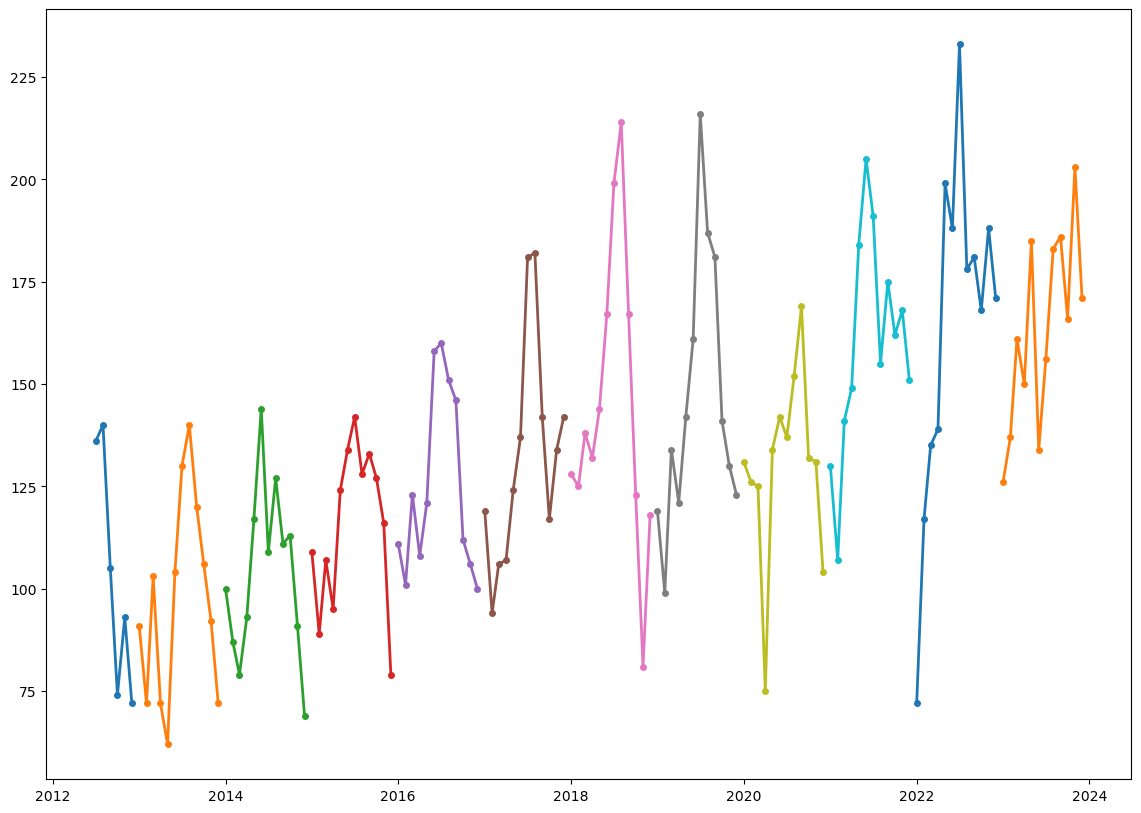

In [ ]:
plt.figure(figsize=(14, 10))
for year in range(2012, 2024):
    df_year = monthly_data[monthly_data['date'].dt.year == year]
    plt.plot(df_year['date'], df_year['count'], marker='o', linewidth=2, markersize=4)
plt.show()